In [7]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys,os, pprint, pickle, math, time, platform
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
pp = pprint.PrettyPrinter(indent=2, width=100)
print('Current working dir: ', os.getcwd())
if '..' not in sys.path:
    print("appending '..' to sys.path")
    sys.path.append('..')
import mrcnn.calculate_map as cmap

syst = platform.system()

#### BCE Training ---------------------------------------------------------------------------------
if syst == 'Windows':
    map_path    = "E:/git_projs/MRCNN3/train_coco/BCE_test_results"
    DIR_WEIGHTS = 'F:/models_coco/train_fcn8L2_BCE_subset/fcn20190112T0000' 
elif syst == 'Linux':
    map_path    = "/home/kbardool/mrcnn3/train_coco/BCE_test_results"
    DIR_WEIGHTS = '/home/kbardool/models_coco/train_fcn8L2_BCE_subset/fcn20190112T0000' 
else :
    raise Error('unrecognized system ')

print(' OS ' , syst, ' : ', map_path)

files = ['fcn_0001.h5', 'fcn_0026.h5', 'fcn_0162.h5', 'fcn_0350.h5', 'fcn_0584.h5', 
          'fcn_0657.h5', 'fcn_0950.h5', 'fcn_1612.h5', 'fcn_1673.h5', 'fcn_2330.h5', 
          'fcn_3348.h5', 'fcn_3742.h5', 'fcn_3816.h5', 'fcn_4345.h5']   #idx 13,14,15,16,17
#### TEST MODE ---------------------------------------------------------------------------------

# if syst == 'Windows':
#     map_path = "E:/git_projs/MRCNN3/train_coco/MSE_eval_method"+eval_method+"_results"
#     DIR_WEIGHTS =  'F:/models_coco/train_fcn8L2_MSE_subset/fcn20190112T0000' 
# elif syst == 'Linux':
#     map_path   = "/home/kbardool/mrcnn3/train_coco/MSE_eval_method"+eval_method+"_results"
#     DIR_WEIGHTS =  '/home/kbardool/models_coco/train_fcn8L2_MSE_subset/fcn20190112T0000' 

# epochs = ['0001', '0150', '0346', '0421', '0450', 
#           '0521', '0687', '0793', '0821', '0940', 
#           '1012', '1127', '1644', '1776', '1848', 
#           '2017', '2084']   #idx 13,14,15,16,17

COLORS = [
    '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
    '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
    '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
    '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']    
# import mrcnn.utils     as utils
# import mrcnn.visualize as visualize


# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
CLASS_NAMES = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush'] 
# class_names = ['ALL CLASSES', 'person', 'car', 'sun','building', 'tree', 'cloud']
CLASS_IDS     = [10, 11, 12, 13, 14, 
                 30, 31, 32, 33, 34, 
                 35, 36, 37, 38, 39, 
                 40, 41, 42, 43, 44, 
                 45, 46, 69, 70, 71, 
                 72, 73]

CLASS_IDS_SG1 = [10, 11, 12, 13, 14, 
                 30, 31, 32, 33, 34, 
                 35, 36]
CLASS_IDS_SG2 = [37, 38, 39, 
                 40, 41, 42, 43, 44, 
                 45, 46, 69, 70, 71, 
                 72, 73]


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Current working dir:  E:\git_projs\MRCNN3\notebooks
 OS  Windows  :  E:/git_projs/MRCNN3/train_coco/BCE_test_results


## Build Mean Average Precision Data Structure 
Using loaded gt_boxes and pr_boxes.
    ALL_DATA is a dictionary keyed by class_id to dictionaries, one for each possible score. Each SCORE dictionary is itrself a dictionary with keys for iOUs 
    between 0.5 and 0.95. Each dictionary entry has the following keys:
    {'iou', 'model_thrs', 'recalls', 'precisions', 'avg_prec'}
    iou :         indicates the iOU threshold of the dictionary entry
    model_thrs:   score thresholds
    recalls   :   recall at threshold
    precision :   precision at threshold


- Create `gt_boxes_class`, `pr_boxes_class` (separated by class)  - 

### Build and Save `map_info_epochxxxx` file from  `gt_boxes`, `pr_boxes`, and `cls_info` data structures 

In [ ]:
for FILE_IDX in [13]:
    epochs = files[FILE_IDX].split('_')[1].replace('.h5','')

    cls_info_file = 'test_cls_info_epoch' +epochs+'_500.pkl'
    pr_boxes_file = 'test_pr_bboxes_epoch'+epochs+'_500.pkl'
    gt_boxes_file = 'test_gt_bboxes_epoch'+epochs+'_500.pkl'
 
    with open(os.path.join(map_path, cls_info_file), 'rb') as infile:
        cls_info = pickle.load(infile)            
    with open(os.path.join(map_path, pr_boxes_file), 'rb') as infile:
        pr_boxes = pickle.load(infile)
    with open(os.path.join(map_path, gt_boxes_file), 'rb') as infile:
        gt_boxes = pickle.load(infile)
    print('loaded :', cls_info_file, '   ', pr_boxes_file, '    ', gt_boxes_file)    

     ## build gt_boxes_class, pr_boxes_class which only containing info for each class
        
    scores    = [ 'mrcnn_score_orig', 'mrcnn_score_norm', 'mrcnn_score_0', 'mrcnn_score_1', 'mrcnn_score_2', 'fcn_score_0', 'fcn_score_1', 'fcn_score_2']
    iou_thresholds = np.arange(0.20, 0.95, 0.05)
    
    all_data = gt_boxes_class = pr_boxes_class = {}
    gt_boxes_class, pr_boxes_class  = cmap.filter_by_class(gt_boxes, pr_boxes, class_ids= CLASS_IDS )

    all_data = cmap.build_mAP_data_structure_by_class(gt_boxes_class, pr_boxes_class,  CLASS_IDS, scores, iou_thresholds)
    all_data[0] = cmap.build_mAP_data_structure_combined(gt_boxes, pr_boxes, scores, iou_thresholds)

    print(all_data.keys())

    ### Save mAP data to file `map_info_epochxxxx.pkl` for future reuse

In [9]:
    map_info_file = 'test_map_info_epoch'+epochs+'.pkl'
    with open(os.path.join(map_path, map_info_file), 'wb') as outfile:
        pickle.dump(all_data, outfile)            
    print(' Datafile :', map_info_file , ' saved')

 Datafile : test_map_info_epoch4345.pkl  saved


### Load previously build `map_info_epochxxxx`  file

In [10]:
FILE_IDX = -1
epochs = files[FILE_IDX].split('_')[1].replace('.h5','')

map_info_file = 'test_map_info_epoch' +epochs+'.pkl'
cls_info_file = 'test_cls_info_epoch' +epochs+'_500.pkl'
pr_boxes_file = 'test_pr_bboxes_epoch'+epochs+'_500.pkl'
gt_boxes_file = 'test_gt_bboxes_epoch'+epochs+'_500.pkl'

with open(os.path.join(map_path, map_info_file), 'rb') as infile:
    all_data = pickle.load(infile)             
print('loaded :', map_info_file)    

with open(os.path.join(map_path, cls_info_file), 'rb') as infile:
    cls_info_load = pickle.load(infile)            
cls_info =  [] 
cls_info.extend([cls_info_load[i] for i in CLASS_IDS])
    
# with open(os.path.join(map_path, pr_boxes_file), 'rb') as infile:
#     pr_boxes = pickle.load(infile)
# with open(os.path.join(map_path, gt_boxes_file), 'rb') as infile:
#     gt_boxes = pickle.load(infile)
print('loaded :', cls_info_file, '   ', pr_boxes_file, '    ', gt_boxes_file)    
    


loaded : test_map_info_epoch4345.pkl
loaded : test_cls_info_epoch4345_500.pkl     test_pr_bboxes_epoch4345_500.pkl      test_gt_bboxes_epoch4345_500.pkl


## Load `gt_boxes`, `pr_boxes`, and `cls_info` data structures 

In [170]:
# path = "F:\\PretrainedModels"
# with open(os.path.join(path,"E:\\git_projs\\MRCNN3\\train_newshapes\\newshapes_predicted_classes_info.pkl"), 'rb') as infile:
#     class_pr_info = pickle.load(infile)            
# with open(os.path.join(path,"newshapes_predicted_bboxes.pkl"), 'rb') as infile:
#     pr_boxes = pickle.load(infile)
# with open(os.path.join(path,"newshapes_ground_truth_bboxes.pkl"), 'rb') as infile:
#     gt_boxes = pickle.load(infile)

# path = "E:\\git_projs\\MRCNN3\\train_coco"
epoch = '2017'
path = "E:\\git_projs\\MRCNN3\\train_newshapes\\training_results"
cls_info_file = 'test_cls_info_epoch'+epoch+'_500.pkl'
pr_boxes_file = 'test_pr_bboxes_epoch'+epoch+'_500.pkl'
gt_boxes_file = 'test_gt_bboxes_epoch'+epoch+'_500.pkl'
# cls_info_file = 'test_cls_info_epoch521_500.pkl'
# pr_boxes_file = 'test_pr_bboxes_epoch521_500.pkl'
# gt_boxes_file = 'test_gt_bboxes_epoch521_500.pkl'
with open(os.path.join(path, cls_info_file), 'rb') as infile:
    cls_info = pickle.load(infile)            
with open(os.path.join(path, pr_boxes_file), 'rb') as infile:
    pr_boxes = pickle.load(infile)
with open(os.path.join(path, gt_boxes_file), 'rb') as infile:
    gt_boxes = pickle.load(infile)

#### Print some info

In [171]:
pr_keys = list(pr_boxes.keys())
gt_keys = list(gt_boxes.keys())
# cls_keys= cls_info
# print(gt_boxes.keys())
print(len(gt_boxes.keys()), len(pr_boxes.keys()), len(cls_info))
print(len(gt_keys), gt_keys[:10])
print(len(pr_keys), pr_keys[:10])
print('keys for GT')
print(gt_boxes[gt_keys[0]].keys())
print('keys for PR')
print(pr_boxes[pr_keys[0]].keys())
print('keys for CLS_INFO')
# print(cls_info.keys())
# pp.pprint(cls_info)
print()
print(' pr key: ',pr_keys[0])
print(pr_boxes[pr_keys[0]]['boxes'])
print(pr_boxes[pr_keys[0]]['scores'])
print(pr_boxes[pr_keys[0]]['class_ids'])
print(pr_boxes[pr_keys[0]]['det_ind'])
print()
print(' gt key: ',gt_keys[0])
print(gt_boxes[gt_keys[0]]['boxes'])
print(gt_boxes[gt_keys[0]]['class_ids'])


500 500 7
500 ['newshapes_00462', 'newshapes_00483', 'newshapes_00211', 'newshapes_00027', 'newshapes_00189', 'newshapes_00123', 'newshapes_00282', 'newshapes_00274', 'newshapes_00055', 'newshapes_00323']
500 ['newshapes_00462', 'newshapes_00483', 'newshapes_00211', 'newshapes_00027', 'newshapes_00189', 'newshapes_00123', 'newshapes_00282', 'newshapes_00274', 'newshapes_00055', 'newshapes_00323']
keys for GT
dict_keys(['boxes', 'class_ids'])
keys for PR
dict_keys(['det_ind', 'boxes', 'mrcnn_score_2', 'mrcnn_score_orig', 'scores', 'mrcnn_score_1', 'fcn_score_0', 'fcn_score_1', 'fcn_score_2', 'class_ids', 'mrcnn_score_0', 'mrcnn_score_norm'])
keys for CLS_INFO

 pr key:  newshapes_00462
[[22.0, 26.0, 41.0, 95.0], [88.0, 27.0, 122.0, 35.0], [83.0, 62.0, 104.0, 108.0], [82.0, 58.0, 115.0, 65.0], [12.0, 68.0, 23.0, 84.0], [88.0, 10.0, 108.0, 61.0]]
[1.0, 0.9998, 0.9997, 0.9996, 0.9986, 0.9947]
[6, 1, 2, 1, 3, 2]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

 gt key:  newshapes_00462
[[13, 68, 24, 85], [2

In [169]:
# for key in sorted(pr_keys[:1000]):  ##  'newshapes_00115'
#     print(key, '  ' ,  pr_boxes[key]['mrcnn_score_1'] == pr_boxes[key]['mrcnn_score_2'] , ' - ',pr_boxes[key]['mrcnn_score_1'],pr_boxes[key]['mrcnn_score_2'])
#     print(key, '  ' , pr_boxes[key]['mrcnn_score_1'] == pr_boxes[key]['mrcnn_score_2'] )

#### `cls_info` - display information

In [83]:
print(cls_info[1]['scores'][:20])
print(cls_info[1]['mrcnn_score_orig'][:20])
print(cls_info[1]['mrcnn_score_norm'][:20])
print()
print(cls_info[1]['mrcnn_score_0'][:20])
print(cls_info[1]['mrcnn_score_1'][:20])
print(cls_info[1]['mrcnn_score_2'][:20])
 

[0.997, 0.7888, 0.9994, 0.9962, 0.8363, 0.981, 0.979, 0.9038, 0.9997, 0.8228, 0.9993, 0.9974, 0.9886, 0.9092, 0.6947, 0.6199, 0.9899, 0.9882, 0.9811, 0.7377]
[0.997, 0.7888, 0.9994, 0.9962, 0.8363, 0.981, 0.979, 0.9038, 0.9997, 0.8228, 0.9993, 0.9974, 0.9886, 0.9092, 0.6947, 0.6199, 0.9899, 0.9882, 0.9811, 0.7377]
[1.0, 0.7911, 1.0, 0.9968, 0.8368, 1.0, 0.998, 0.9213, 1.0, 0.8231, 1.0, 0.9981, 0.9893, 0.9098, 0.6952, 0.6204, 1.0, 1.0, 0.9928, 0.7465]

[0.9319, 0.6913, 0.9499, 0.9017, 0.7313, 0.9047, 0.9056, 0.8052, 0.95, 0.7194, 0.9323, 0.9063, 0.8979, 0.795, 0.6843, 0.5972, 0.9324, 0.9319, 0.9014, 0.6949]
[0.6592, 0.4831, 0.7115, 0.6624, 0.519, 0.6646, 0.682, 0.5778, 0.6961, 0.505, 0.6606, 0.6656, 0.6584, 0.5556, 0.471, 0.431, 0.6557, 0.6592, 0.6643, 0.4764]
[0.6592, 0.4831, 0.7115, 0.6624, 0.519, 0.6646, 0.682, 0.5778, 0.6611, 0.6079, 0.6606, 0.6656, 0.6584, 0.5556, 0.471, 0.431, 0.6557, 0.6592, 0.6643, 0.4764]


In [ ]:
# gt_boxes_class, pr_boxes_class = filter_by_class(gt_boxes, pr_boxes, class_id= 2)
# print(len(pr_boxes_class.keys()), len(gt_boxes_class.keys()))

In [ ]:
# for img_id in pred_boxes.keys():
#     arg_sort = np.argsort(pred_boxes[img_id]['scores'])
#     pred_boxes[img_id]['scores'] = np.array(pred_boxes[img_id]['scores'])[arg_sort].tolist()
#     pred_boxes[img_id]['boxes']  = np.array(pred_boxes[img_id]['boxes'])[arg_sort].tolist()

# print(type(class_pr_info), type(pr_boxes))    
# pr_keys = list(gt_boxes.keys())
# print(len(pr_keys))
# pp.pprint(class_pr_info[6].keys())

# class_stats  = {}
# class_stats.setdefault('avg', [cls['avg'] for cls in class_pr_info])
# class_stats.setdefault('pct', [cls['percentiles'] for cls in class_pr_info])   
# pp.pprint(class_stats)

# print(len(pr_keys), pr_keys[0])
# print(pr_boxes[pr_keys[0]])

# print(pred_boxes[pr_keys[0]])
# print(len(gt_boxes.keys()))

#### Print some info

In [170]:
print(gt_boxes['newshapes_00469'])
print(gt_boxes_class[1]['newshapes_00469'])
print()
pp.pprint(pr_boxes['newshapes_00469'])
pp.pprint(pr_boxes_class[1]['newshapes_00469'])

{'class_ids': [3, 6, 6, 5, 4, 5, 1, 1, 2, 5, 2], 'boxes': [[11, 14, 28, 31], [18, 43, 24, 78], [23, 28, 38, 99], [36, 76, 51, 90], [46, 40, 91, 73], [66, 70, 94, 96], [66, 101, 91, 106], [68, 59, 93, 64], [80, 3, 101, 52], [83, 83, 119, 117], [92, 25, 116, 84]]}
{'class_ids': [1, 1], 'boxes': [[66, 101, 91, 106], [68, 59, 93, 64]]}

{ 'boxes': [ [81.0, 6.0, 99.0, 47.0],
             [94.0, 25.0, 114.0, 87.0],
             [11.0, 13.0, 28.0, 30.0],
             [66.0, 71.0, 93.0, 97.0],
             [22.0, 30.0, 37.0, 100.0],
             [70.0, 58.0, 93.0, 64.0],
             [37.0, 77.0, 52.0, 90.0],
             [84.0, 83.0, 120.0, 117.0],
             [68.0, 100.0, 91.0, 106.0],
             [42.0, 46.0, 92.0, 73.0],
             [18.0, 43.0, 23.0, 79.0]],
  'class_ids': [2, 2, 3, 5, 6, 1, 5, 5, 1, 4, 6],
  'det_ind': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
  'fcn_score_0': [ -110.5106,
                   -192.0784,
                   -50.6154,
                   -1

In [106]:
# class_data = all_data[1]
# score_key = 'scores'
# for idx, iou_key in enumerate(sorted(class_data[score_key])):
#     print(idx, iou_key)
bb = [0.7777, 0.7569, 0.6442, 0.4946, 0.3545, 0.1565, 0.0654, 0.0264, 0.005]
avg_precs = [" {:10.4f}".format(ap) for ap in bb]
# avg_precs = [str(ap) for ap in bb]
b1 = ""
print(b1.join(avg_precs))

ValueError: Invalid format specifier

## Display distribution of various scores 

D:\Program Files\Anaconda3\envs\TF\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
D:\Program Files\Anaconda3\envs\TF\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\Program Files\Anaconda3\envs\TF\lib\site-packages\numpy\core\_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
D:\Program Files\Anaconda3\envs\TF\lib\site-packages\numpy\core\_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
D:\Program Files\Anaconda3\envs\TF\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\Program Files\Anaconda3\envs\TF\lib\site-packages\seaborn\distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0

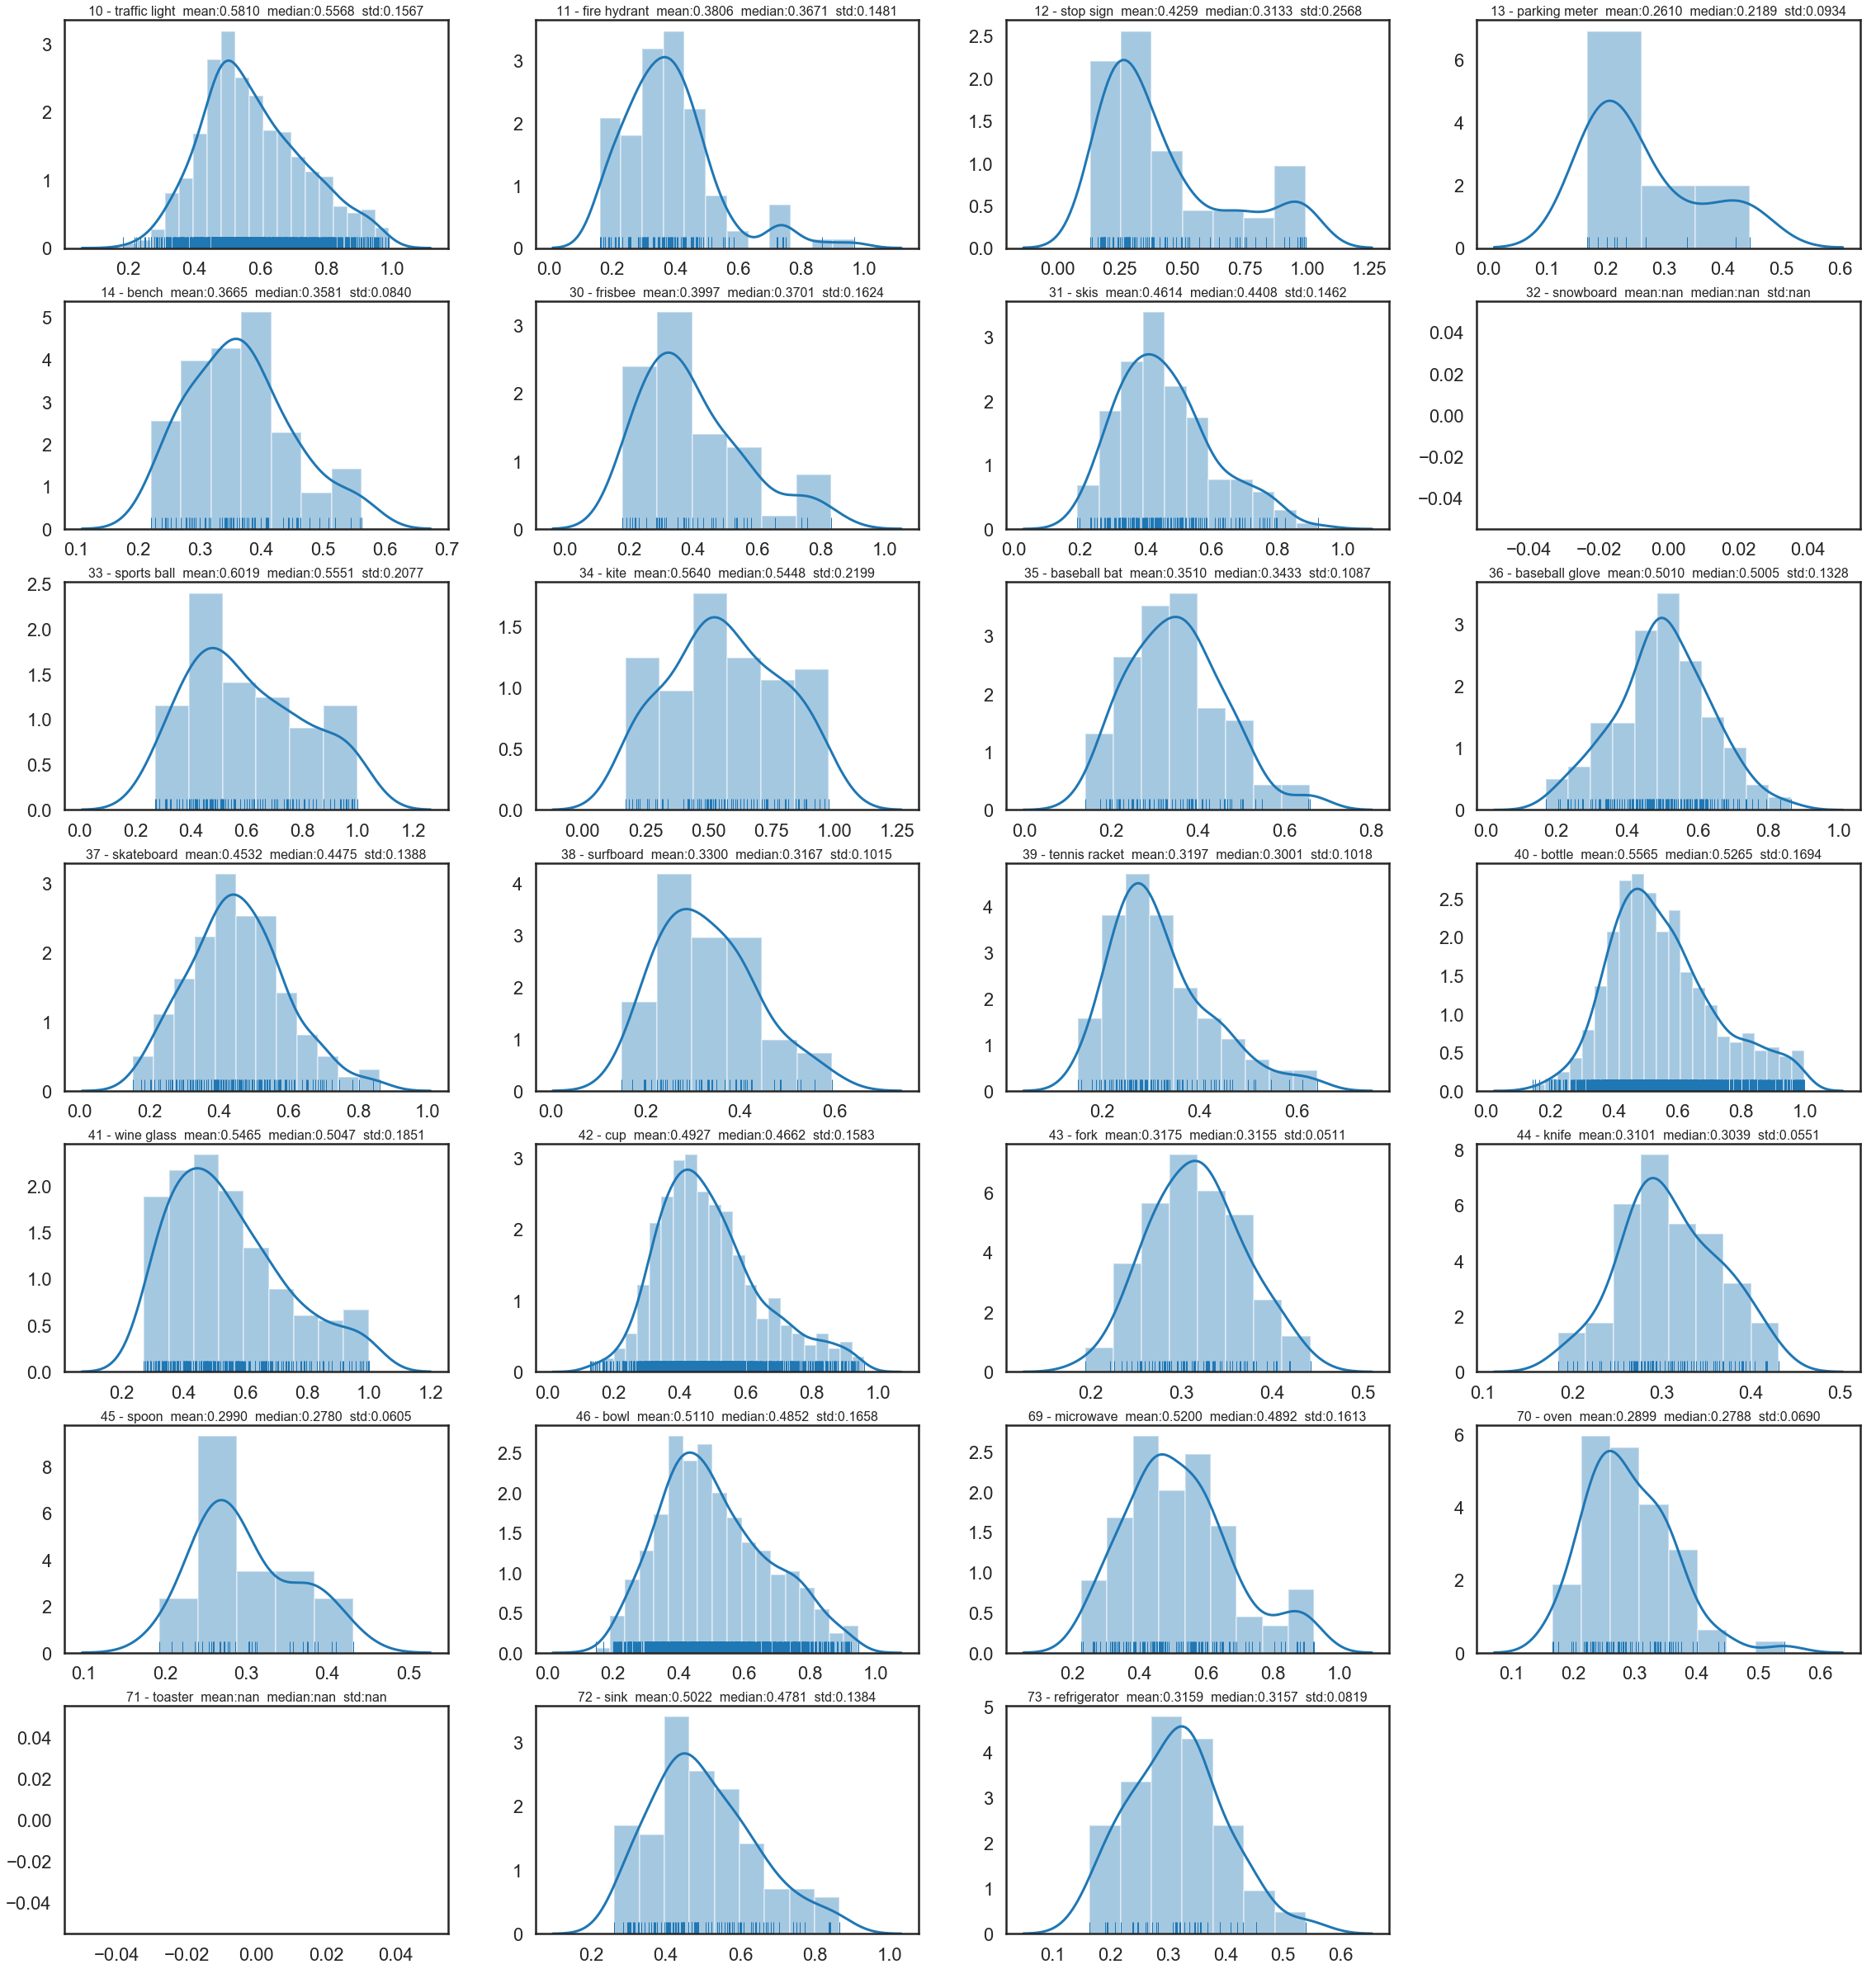

In [12]:
cmap.plot_score_distribution(cls_info, 'mrcnn_score_orig')

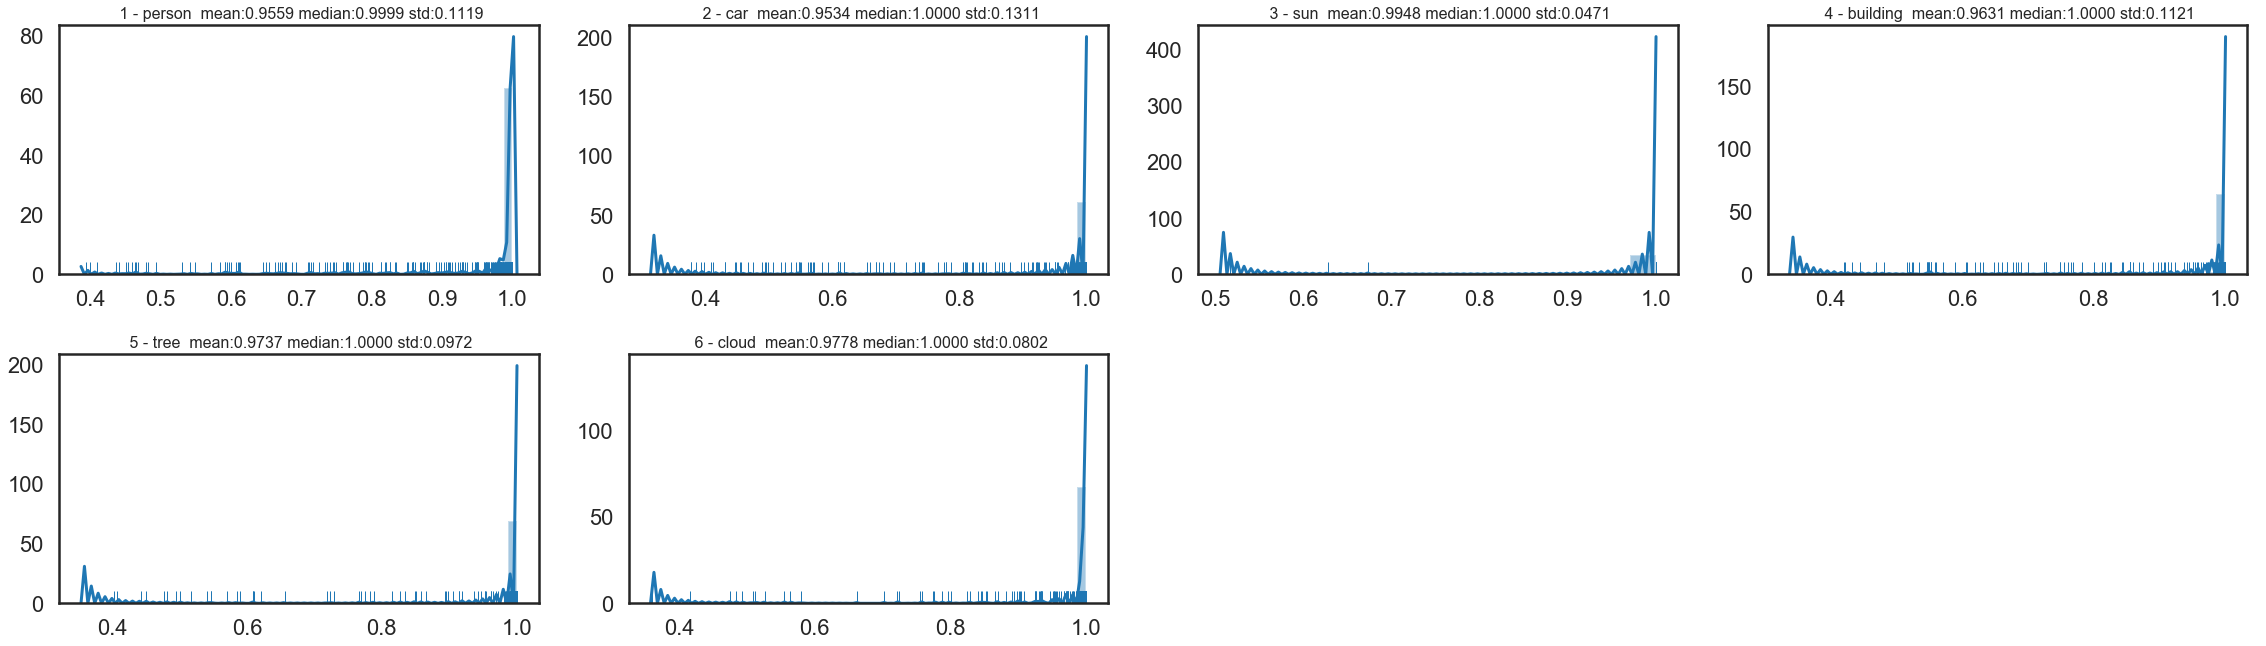

In [65]:
plot_score_distribution(cls_info, 'mrcnn_score_norm')

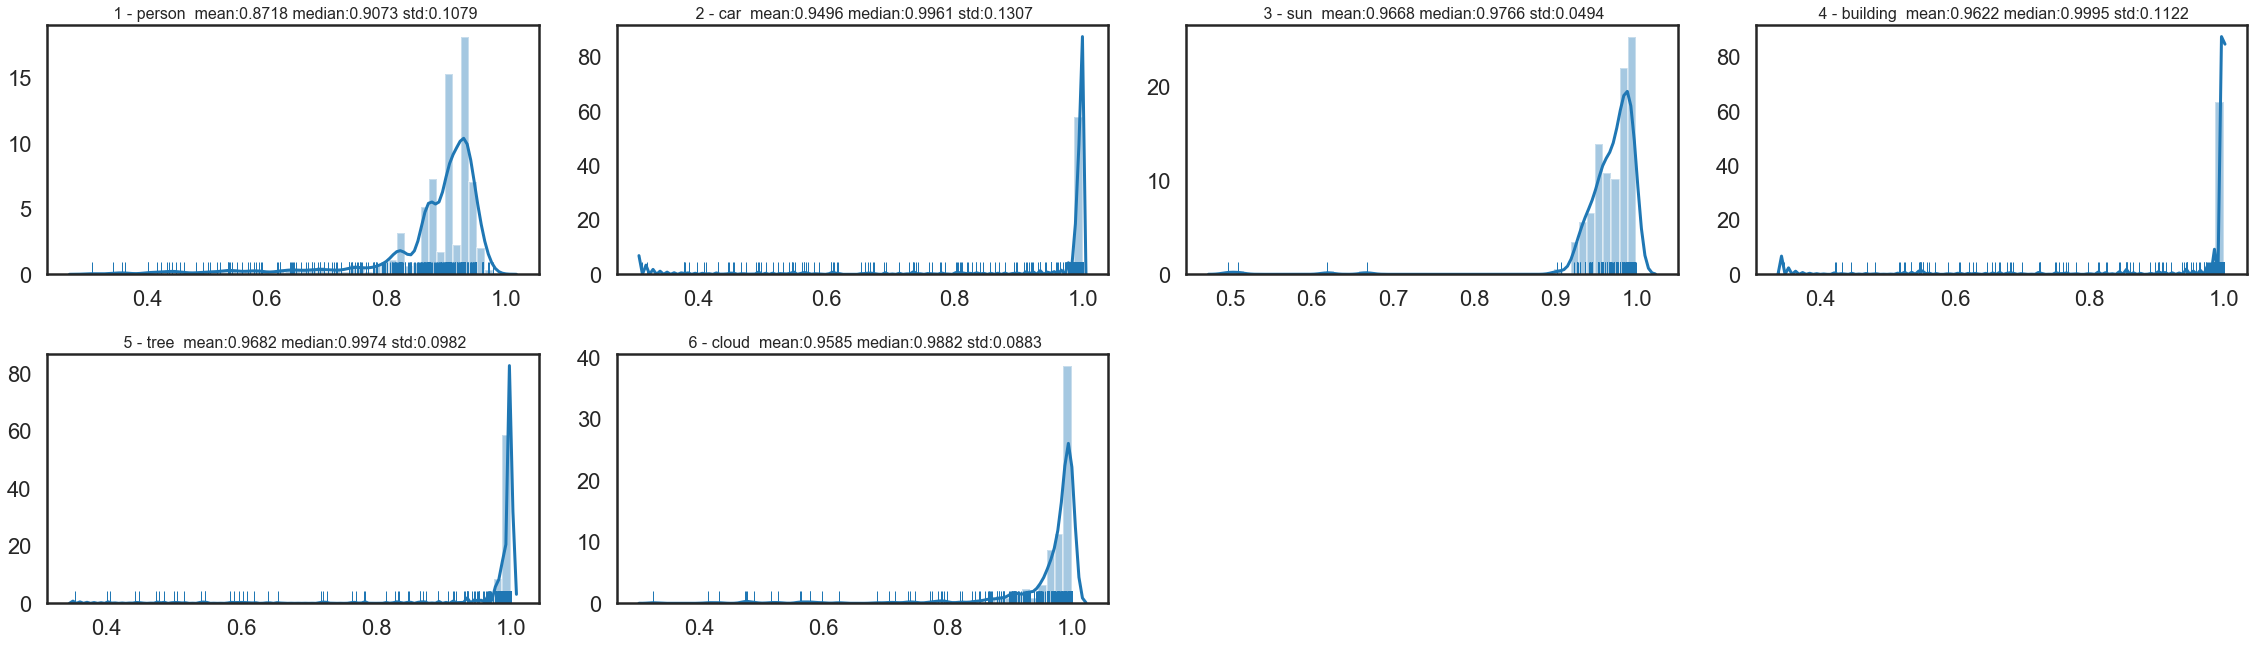

In [66]:
plot_score_distribution(cls_info, 'mrcnn_score_0')

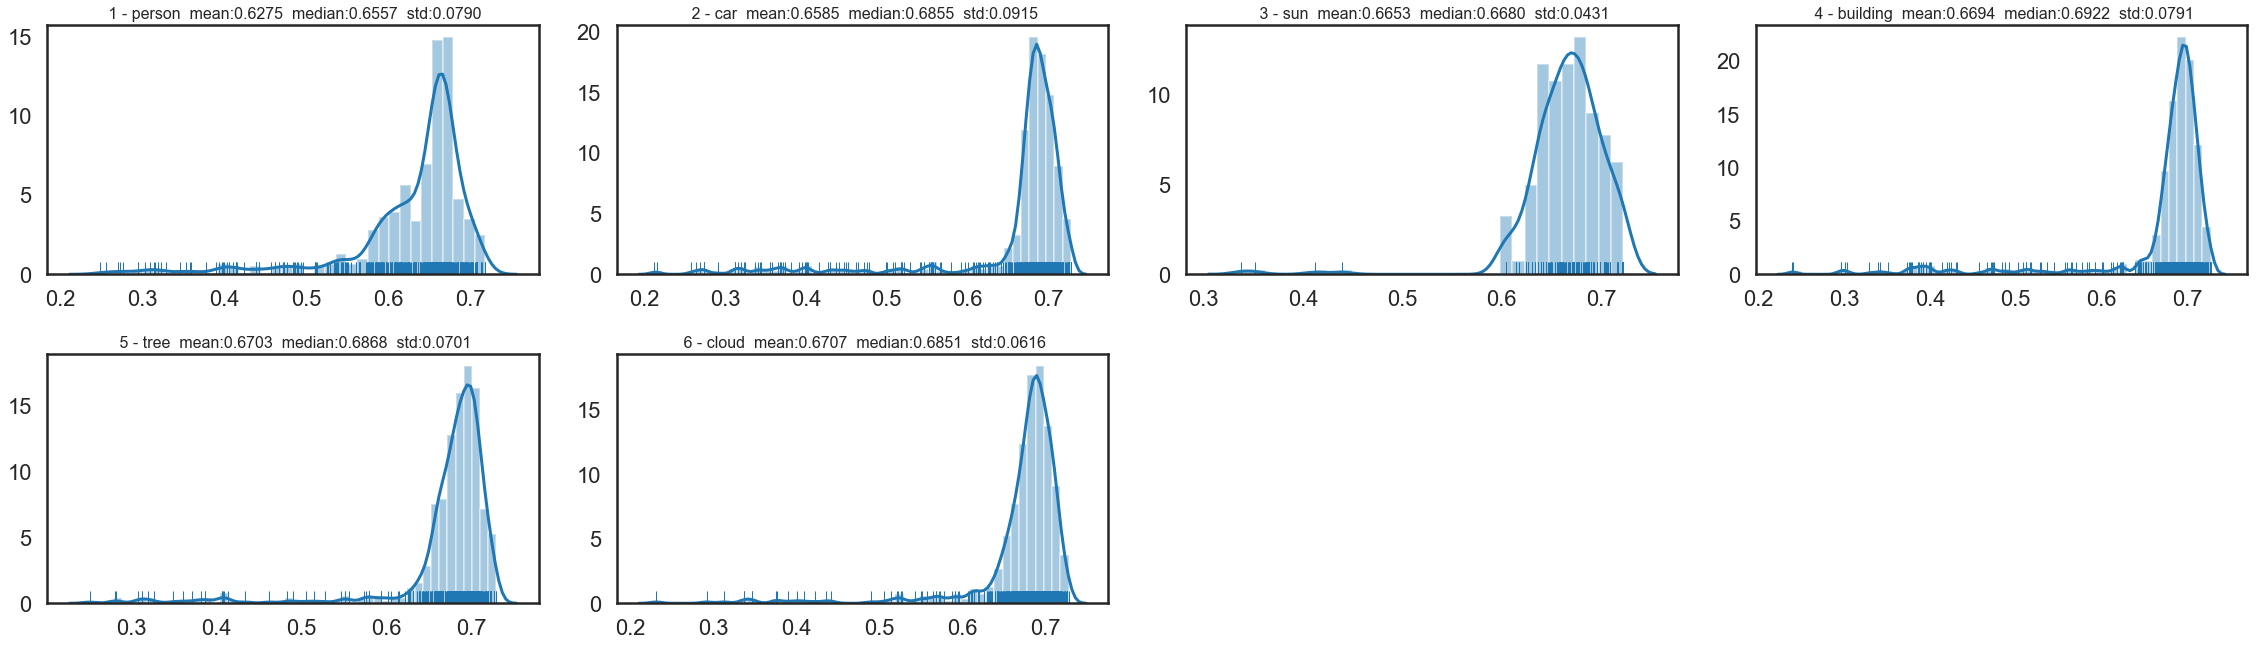

In [68]:
plot_score_distribution(cls_info, 'mrcnn_score_1')

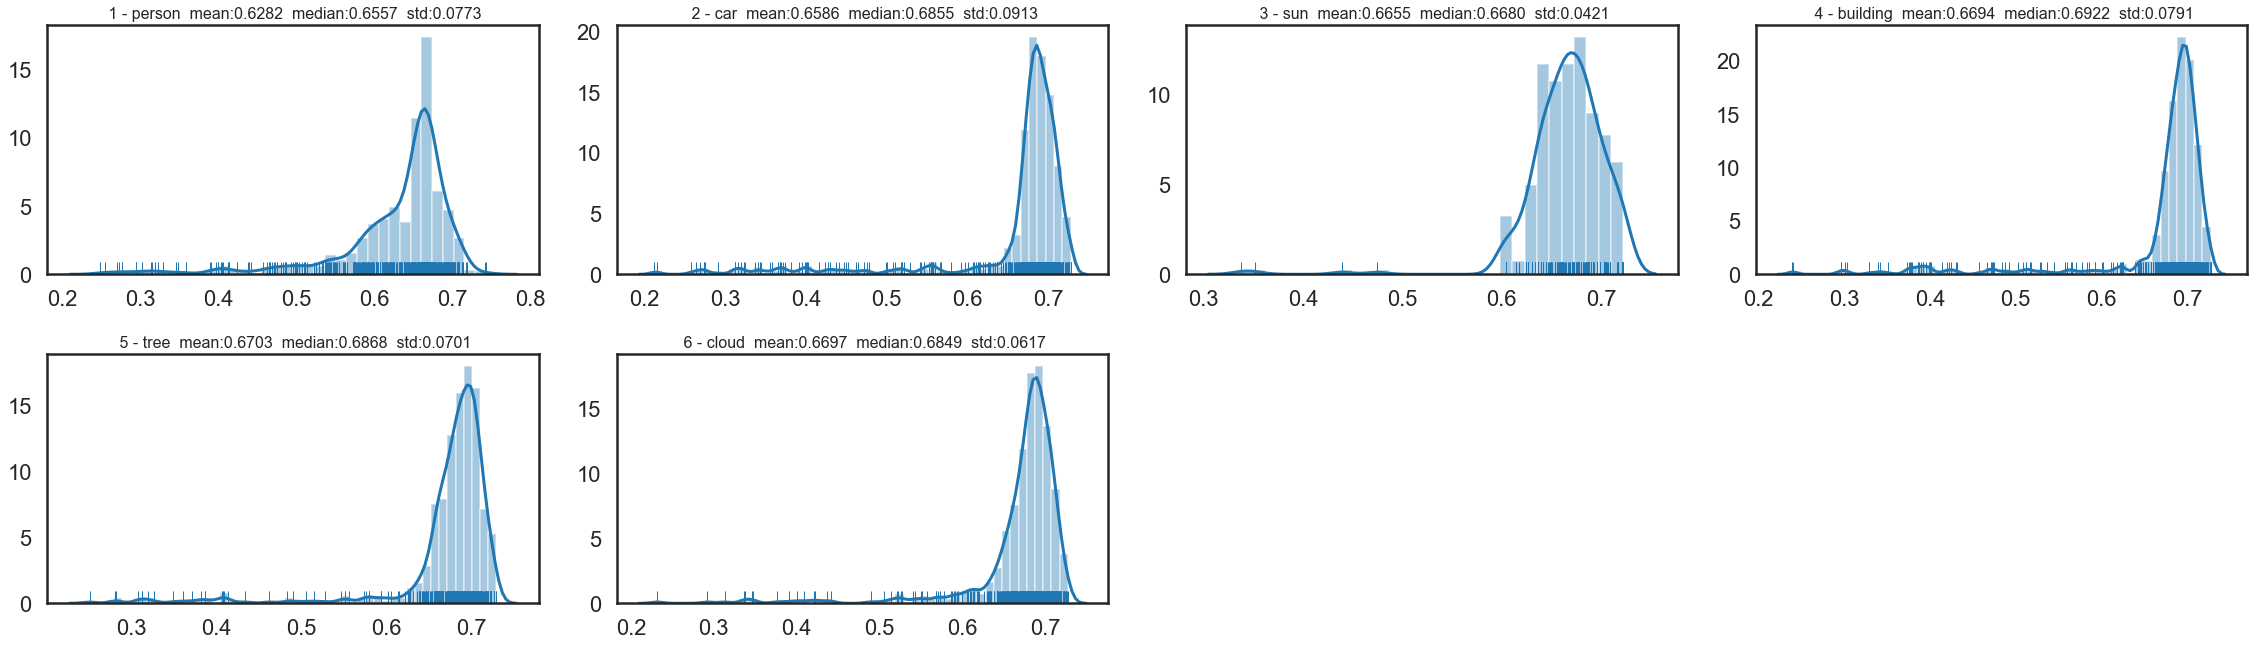

In [69]:
plot_score_distribution(cls_info, 'mrcnn_score_2')

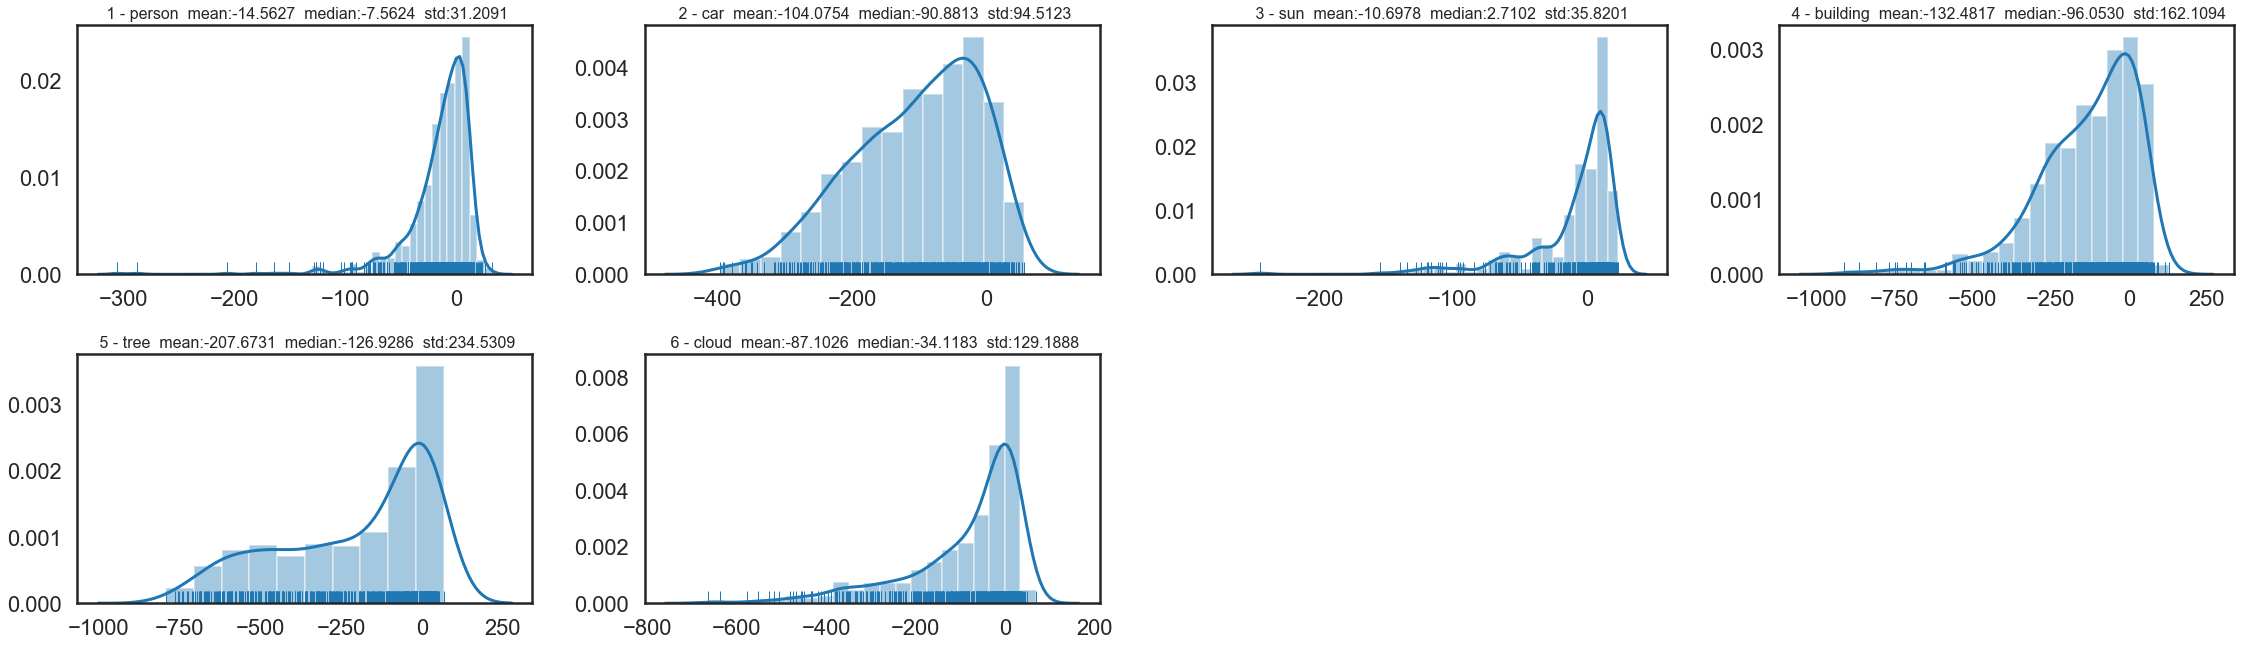

In [70]:
plot_score_distribution(cls_info, 'fcn_score_0')

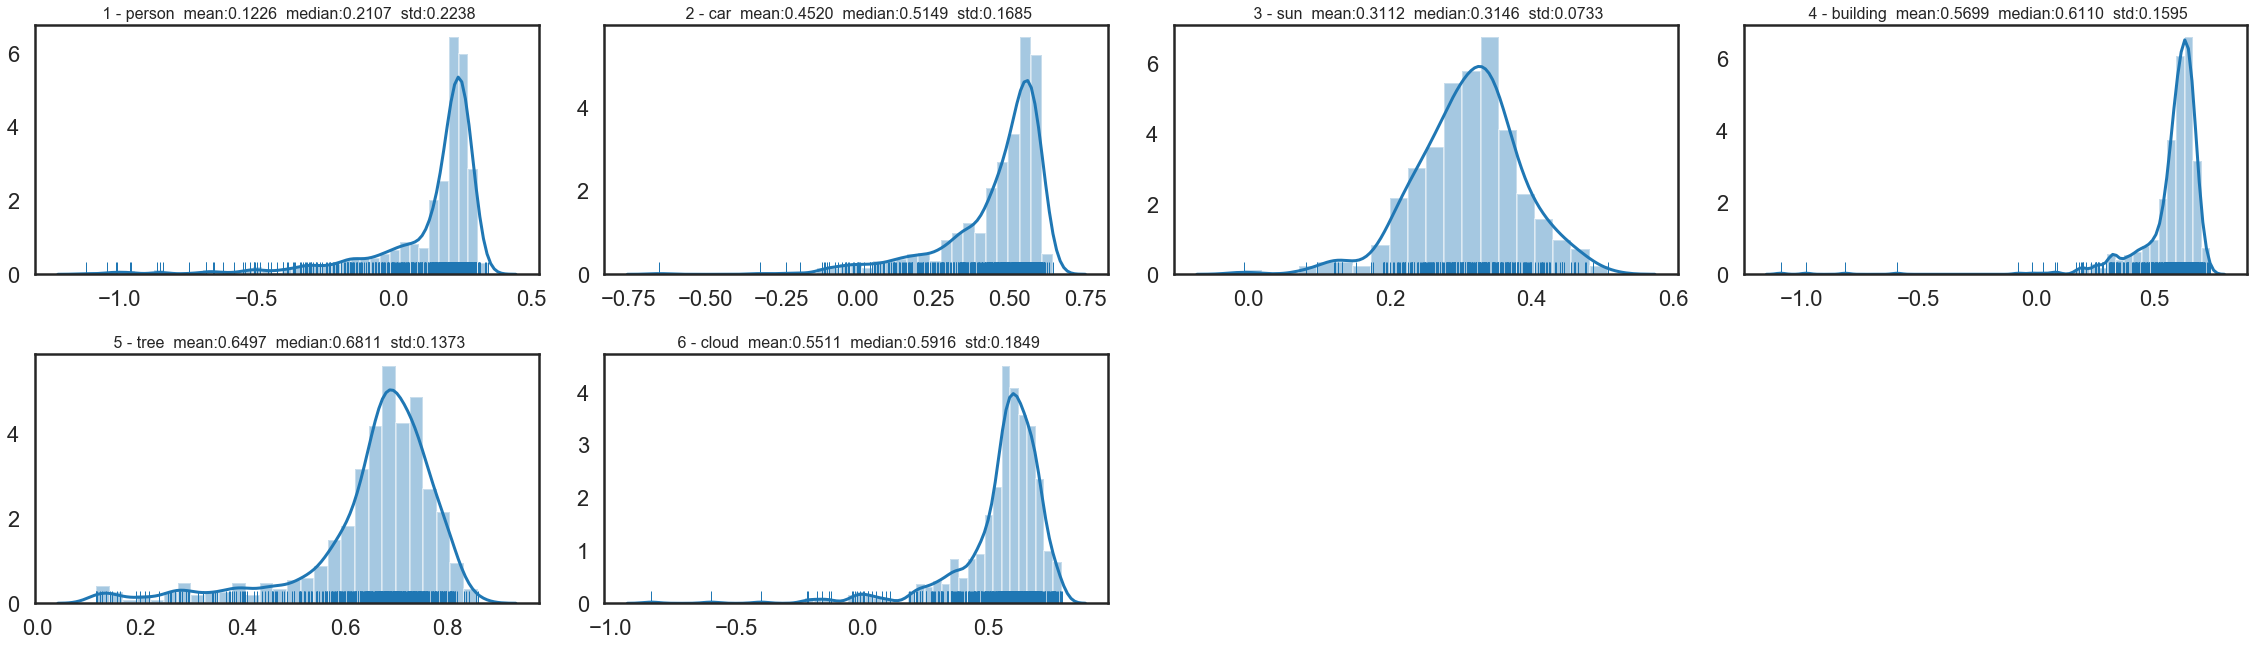

In [71]:
plot_score_distribution(cls_info, 'fcn_score_1')

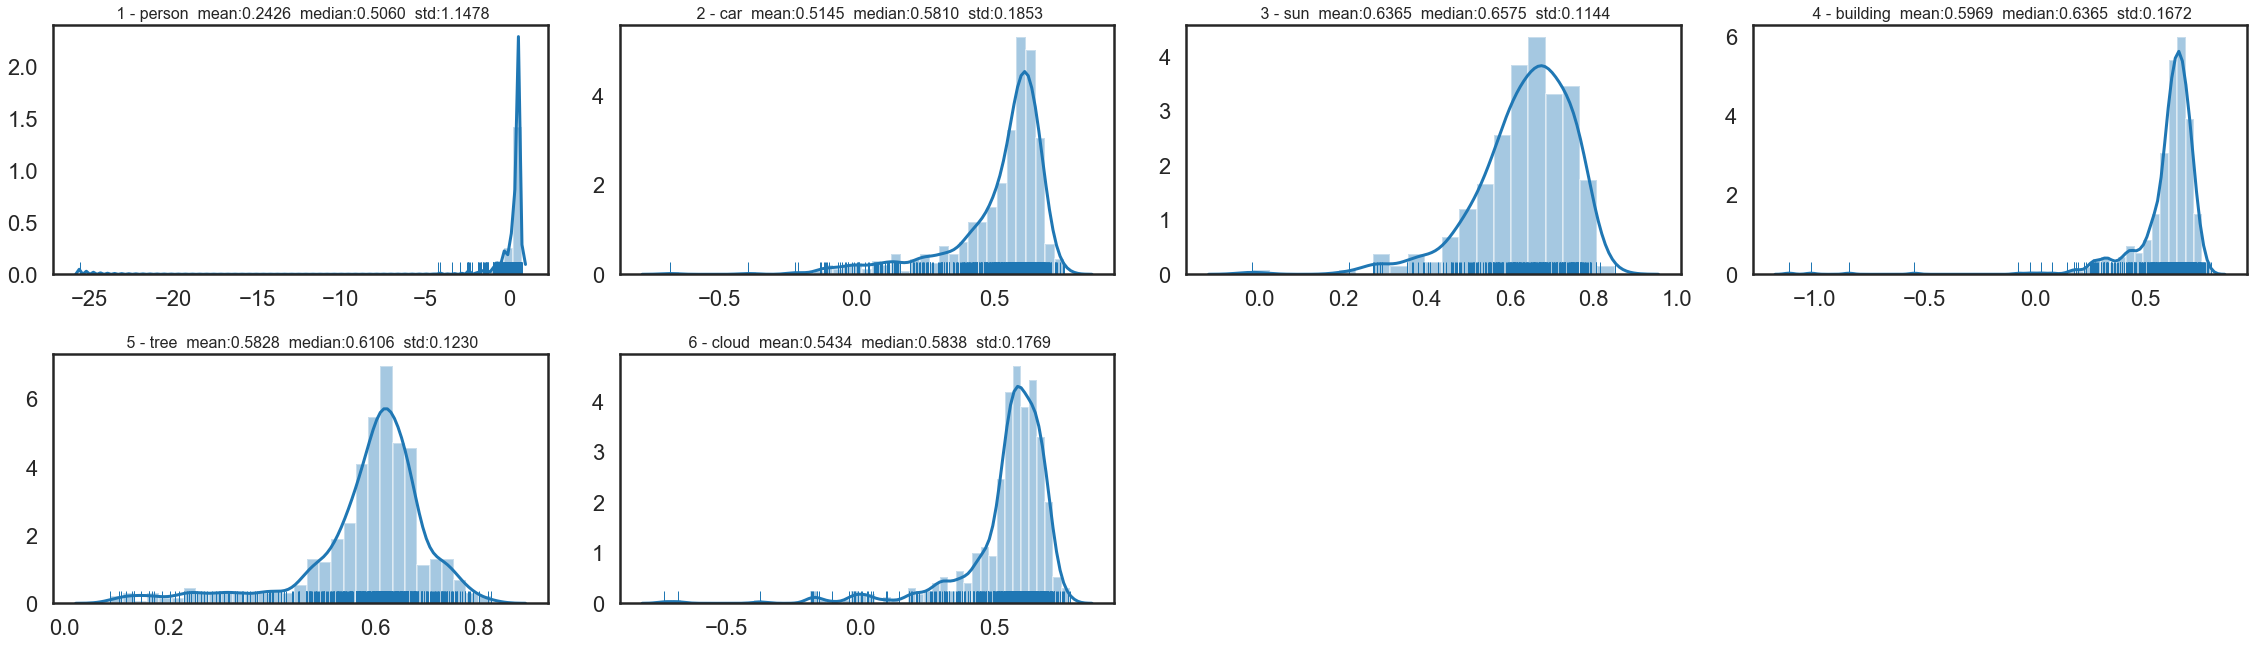

In [72]:
plot_score_distribution(cls_info, 'fcn_score_2')

#### display of gt_boxes_class, pr_boxes_class

In [ ]:
# gt_boxes_class, pr_boxes_class = filter_by_class(gt_boxes, pr_boxes, class_id= 5)
gt_boxes_class, pr_boxes_class = filter_by_class_2(gt_boxes, pr_boxes, class_id= 2)
print(type(gt_boxes_class), type(pr_boxes_class))
pr_keys = list(pr_boxes_class.keys())
gt_keys = list(gt_boxes_class.keys())
print(len(gt_boxes.keys()), len(pr_boxes.keys()))
print(len(gt_keys), gt_keys[:10])
print(len(pr_keys), pr_keys[:10])
sel_gt_keys = gt_keys[:3]
sel_pr_keys = pr_keys[:3]
# pp.pprint(pr_boxes['newshapes_00002'])
for key in gt_keys[:3]:
    print('-----------------------')
    print('Key: ', key)
    print('-----------------------')
    pp.pprint(pr_boxes_class[key])
    print()
    pp.pprint(gt_boxes_class[key])

In [ ]:

# class_ids     = [10, 11, 12, 13, 14, 15, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 69, 70, 71, 72, 73]
# Runs it for one IoU threshold


##  Create `gt_boxes_class`, `pr_boxes_class` (separated by class)

In [173]:
class_ids = [1,2,3,4,5,6]
## build gt_boxes_class, pr_boxes_class which only containing info for each class 
gt_boxes_class = pr_boxes_class = {}

gt_boxes_class, pr_boxes_class  = cmap.filter_by_class(gt_boxes, pr_boxes, class_ids= class_ids)

print(gt_boxes_class[1]['newshapes_00492'].keys())
print(gt_boxes_class[1]['newshapes_00492']['class_ids'])
print(gt_boxes_class[1]['newshapes_00492']['boxes'])

print(gt_boxes_class.keys(), pr_boxes_class.keys())

 # pr keys : 500 # gt_keys:  500
 Processing class :  1
newshapes_00325
indexes for gt_boxes:  [4, 5, 9, 10]
indexes for pr_boxes:  [4, 7, 8, 9, 10]
 Processing class :  2
newshapes_00325
indexes for gt_boxes:  [6, 8]
indexes for pr_boxes:  [0, 3, 12]
 Processing class :  3
newshapes_00325
indexes for gt_boxes:  [0]
indexes for pr_boxes:  [1]
 Processing class :  4
newshapes_00325
indexes for gt_boxes:  [3]
indexes for pr_boxes:  [2, 11, 13]
 Processing class :  5
newshapes_00325
indexes for gt_boxes:  [2, 7]
indexes for pr_boxes:  [6, 14]
 Processing class :  6
newshapes_00325
indexes for gt_boxes:  [1]
indexes for pr_boxes:  [5]
dict_keys(['boxes', 'class_ids'])
[1]
[[71, 93, 91, 100]]
dict_keys([1, 2, 3, 4, 5, 6]) dict_keys([1, 2, 3, 4, 5, 6])


In [ ]:
# class_ids     = [10, 11, 12, 13, 14, 
#                  15, 30, 31, 32, 33, 
#                  34, 35, 36, 37, 38, 
#                  39, 40, 41, 42, 43,
#                  44, 46, 69, 70, 71, 
#                  72, 73]
# class_ids = [1,2,3,4,5,6]
# ## build gt_boxes_class, pr_boxes_class which only containing info for each class 
# gt_boxes_class_1 = {}
# pr_boxes_class_1 = {}

# for cls in class_ids :
#     print('class id :', cls)
#     a, b = cmap.filter_by_class(gt_boxes, pr_boxes, class_id= cls)
#     gt_boxes_class_1[cls] = a
#     pr_boxes_class_1[cls] = b
# print(gt_boxes_class_1.keys())    
# print(pr_boxes_class_1.keys())    
# print(gt_boxes_class_1[1]['newshapes_00492'].keys())


# key = 'newshapes_00321' 
# cls = 3
# print(gt_boxes_class_1[cls][key]['class_ids'])
# print(gt_boxes_class_1[cls][key]['boxes'])
# print(gt_boxes_class[cls][key]['class_ids'])
# print(gt_boxes_class[cls][key]['boxes'])

# print(' ==== P')
# print(pr_boxes_class_1[cls][key]['class_ids'])
# print(pr_boxes_class_1[cls][key]['boxes'])
# print(pr_boxes_class[cls][key]['class_ids'])
# print(pr_boxes_class[cls][key]['boxes'])

In [176]:
for cls in [1,2,3,4,5,6]:
    print('========================================')
    for i in pr_boxes_class[cls]:
        print(cls, '  ', i, len(pr_boxes_class[cls][i]['class_ids']), len(pr_boxes_class[cls][i]['boxes']))
        print(cls, '  ', i, len(gt_boxes_class[cls][i]['class_ids']), len(gt_boxes_class[cls][i]['boxes']))

1    newshapes_00462 2 2
1    newshapes_00462 2 2
1    newshapes_00180 1 1
1    newshapes_00180 1 1
1    newshapes_00483 4 4
1    newshapes_00483 4 4
1    newshapes_00211 4 4
1    newshapes_00211 4 4
1    newshapes_00249 0 0
1    newshapes_00249 1 1
1    newshapes_00189 3 3
1    newshapes_00189 2 2
1    newshapes_00123 1 1
1    newshapes_00123 1 1
1    newshapes_00293 2 2
1    newshapes_00293 2 2
1    newshapes_00125 3 3
1    newshapes_00125 3 3
1    newshapes_00278 1 1
1    newshapes_00278 1 1
1    newshapes_00158 4 4
1    newshapes_00158 4 4
1    newshapes_00198 1 1
1    newshapes_00198 1 1
1    newshapes_00070 1 1
1    newshapes_00070 2 2
1    newshapes_00226 6 6
1    newshapes_00226 5 5
1    newshapes_00386 2 2
1    newshapes_00386 2 2
1    newshapes_00388 5 5
1    newshapes_00388 4 4
1    newshapes_00307 3 3
1    newshapes_00307 3 3
1    newshapes_00364 2 2
1    newshapes_00364 1 1
1    newshapes_00215 1 1
1    newshapes_00215 1 1
1    newshapes_00383 1 1
1    newshapes_00383 1 1


1    newshapes_00113 2 2
1    newshapes_00232 2 2
1    newshapes_00232 2 2
1    newshapes_00047 2 2
1    newshapes_00047 2 2
1    newshapes_00341 1 1
1    newshapes_00341 1 1
1    newshapes_00347 4 4
1    newshapes_00347 4 4
1    newshapes_00321 1 1
1    newshapes_00321 1 1
1    newshapes_00058 2 2
1    newshapes_00058 2 2
1    newshapes_00252 2 2
1    newshapes_00252 2 2
1    newshapes_00190 2 2
1    newshapes_00190 2 2
1    newshapes_00068 2 2
1    newshapes_00068 2 2
1    newshapes_00020 3 3
1    newshapes_00020 3 3
1    newshapes_00196 1 1
1    newshapes_00196 1 1
1    newshapes_00426 2 2
1    newshapes_00426 2 2
1    newshapes_00335 1 1
1    newshapes_00335 1 1
1    newshapes_00382 1 1
1    newshapes_00382 1 1
1    newshapes_00407 2 2
1    newshapes_00407 2 2
1    newshapes_00156 3 3
1    newshapes_00156 2 2
1    newshapes_00452 2 2
1    newshapes_00452 2 2
1    newshapes_00046 1 1
1    newshapes_00046 1 1
1    newshapes_00489 2 2
1    newshapes_00489 2 2
1    newshapes_00336 1 1


2    newshapes_00282 1 1
2    newshapes_00282 1 1
2    newshapes_00305 1 1
2    newshapes_00305 2 2
2    newshapes_00125 1 1
2    newshapes_00125 0 0
2    newshapes_00278 2 2
2    newshapes_00278 2 2
2    newshapes_00225 1 1
2    newshapes_00225 1 1
2    newshapes_00158 5 5
2    newshapes_00158 3 3
2    newshapes_00198 1 1
2    newshapes_00198 1 1
2    newshapes_00070 2 2
2    newshapes_00070 1 1
2    newshapes_00226 2 2
2    newshapes_00226 0 0
2    newshapes_00386 2 2
2    newshapes_00386 2 2
2    newshapes_00388 3 3
2    newshapes_00388 3 3
2    newshapes_00307 1 1
2    newshapes_00307 1 1
2    newshapes_00257 1 1
2    newshapes_00257 1 1
2    newshapes_00215 1 1
2    newshapes_00215 1 1
2    newshapes_00383 1 1
2    newshapes_00383 1 1
2    newshapes_00207 3 3
2    newshapes_00207 2 2
2    newshapes_00192 2 2
2    newshapes_00192 1 1
2    newshapes_00242 3 3
2    newshapes_00242 2 2
2    newshapes_00089 1 1
2    newshapes_00089 1 1
2    newshapes_00297 2 2
2    newshapes_00297 2 2


2    newshapes_00193 1 1
2    newshapes_00193 1 1
2    newshapes_00181 0 0
2    newshapes_00181 1 1
2    newshapes_00186 2 2
2    newshapes_00186 1 1
2    newshapes_00046 1 1
2    newshapes_00046 1 1
2    newshapes_00304 1 1
2    newshapes_00304 1 1
2    newshapes_00478 2 2
2    newshapes_00478 2 2
2    newshapes_00129 5 5
2    newshapes_00129 5 5
2    newshapes_00460 1 1
2    newshapes_00460 1 1
2    newshapes_00430 1 1
2    newshapes_00430 1 1
2    newshapes_00228 3 3
2    newshapes_00228 2 2
2    newshapes_00491 3 3
2    newshapes_00491 2 2
2    newshapes_00086 2 2
2    newshapes_00086 2 2
2    newshapes_00441 3 3
2    newshapes_00441 2 2
2    newshapes_00427 1 1
2    newshapes_00427 1 1
2    newshapes_00069 2 2
2    newshapes_00069 2 2
2    newshapes_00339 1 1
2    newshapes_00339 1 1
2    newshapes_00185 2 2
2    newshapes_00185 1 1
2    newshapes_00418 1 1
2    newshapes_00418 1 1
2    newshapes_00288 4 4
2    newshapes_00288 2 2
2    newshapes_00231 2 2
2    newshapes_00231 1 1


3    newshapes_00150 1 1
3    newshapes_00150 0 0
3    newshapes_00062 1 1
3    newshapes_00062 1 1
3    newshapes_00467 1 1
3    newshapes_00467 1 1
3    newshapes_00311 1 1
3    newshapes_00311 1 1
3    newshapes_00013 1 1
3    newshapes_00013 1 1
3    newshapes_00175 1 1
3    newshapes_00175 1 1
3    newshapes_00337 1 1
3    newshapes_00337 1 1
3    newshapes_00260 1 1
3    newshapes_00260 1 1
3    newshapes_00494 1 1
3    newshapes_00494 1 1
3    newshapes_00330 1 1
3    newshapes_00330 1 1
3    newshapes_00043 1 1
3    newshapes_00043 1 1
3    newshapes_00036 1 1
3    newshapes_00036 1 1
3    newshapes_00045 1 1
3    newshapes_00045 1 1
3    newshapes_00118 1 1
3    newshapes_00118 1 1
3    newshapes_00246 1 1
3    newshapes_00246 1 1
3    newshapes_00380 2 2
3    newshapes_00380 1 1
3    newshapes_00000 1 1
3    newshapes_00000 1 1
3    newshapes_00294 1 1
3    newshapes_00294 1 1
3    newshapes_00091 1 1
3    newshapes_00091 1 1
3    newshapes_00334 1 1
3    newshapes_00334 1 1


4    newshapes_00479 1 1
4    newshapes_00479 1 1
4    newshapes_00238 2 2
4    newshapes_00238 2 2
4    newshapes_00429 1 1
4    newshapes_00429 1 1
4    newshapes_00220 1 1
4    newshapes_00220 1 1
4    newshapes_00018 3 3
4    newshapes_00018 3 3
4    newshapes_00432 2 2
4    newshapes_00432 2 2
4    newshapes_00372 1 1
4    newshapes_00372 1 1
4    newshapes_00174 3 3
4    newshapes_00174 3 3
4    newshapes_00021 3 3
4    newshapes_00021 2 2
4    newshapes_00136 1 1
4    newshapes_00136 1 1
4    newshapes_00280 1 1
4    newshapes_00280 1 1
4    newshapes_00179 1 1
4    newshapes_00179 1 1
4    newshapes_00130 4 4
4    newshapes_00130 2 2
4    newshapes_00035 4 4
4    newshapes_00035 3 3
4    newshapes_00319 3 3
4    newshapes_00319 2 2
4    newshapes_00442 2 2
4    newshapes_00442 1 1
4    newshapes_00113 1 1
4    newshapes_00113 1 1
4    newshapes_00138 2 2
4    newshapes_00138 1 1
4    newshapes_00409 2 2
4    newshapes_00409 2 2
4    newshapes_00112 3 3
4    newshapes_00112 3 3


4    newshapes_00298 1 1
4    newshapes_00446 1 1
4    newshapes_00446 1 1
4    newshapes_00451 1 1
4    newshapes_00451 1 1
4    newshapes_00059 1 1
4    newshapes_00059 1 1
4    newshapes_00476 1 1
4    newshapes_00476 1 1
4    newshapes_00359 1 1
4    newshapes_00359 1 1
4    newshapes_00183 3 3
4    newshapes_00183 3 3
4    newshapes_00029 2 2
4    newshapes_00029 2 2
4    newshapes_00024 1 1
4    newshapes_00024 1 1
4    newshapes_00077 1 1
4    newshapes_00077 1 1
4    newshapes_00037 1 1
4    newshapes_00037 1 1
4    newshapes_00281 1 1
4    newshapes_00281 1 1
4    newshapes_00086 5 5
4    newshapes_00086 3 3
4    newshapes_00301 4 4
4    newshapes_00301 2 2
4    newshapes_00326 1 1
4    newshapes_00326 1 1
4    newshapes_00159 2 2
4    newshapes_00159 2 2
4    newshapes_00405 1 1
4    newshapes_00405 1 1
4    newshapes_00458 1 1
4    newshapes_00458 1 1
4    newshapes_00498 1 1
4    newshapes_00498 1 1
4    newshapes_00443 1 1
4    newshapes_00443 1 1
4    newshapes_00145 1 1


5    newshapes_00222 2 2
5    newshapes_00222 2 2
5    newshapes_00137 1 1
5    newshapes_00137 1 1
5    newshapes_00441 1 1
5    newshapes_00441 1 1
5    newshapes_00214 2 2
5    newshapes_00214 2 2
5    newshapes_00444 2 2
5    newshapes_00444 2 2
5    newshapes_00369 1 1
5    newshapes_00369 1 1
5    newshapes_00400 1 1
5    newshapes_00400 1 1
5    newshapes_00402 1 1
5    newshapes_00402 1 1
5    newshapes_00480 1 1
5    newshapes_00480 1 1
5    newshapes_00164 1 1
5    newshapes_00164 1 1
5    newshapes_00265 2 2
5    newshapes_00265 2 2
5    newshapes_00270 1 1
5    newshapes_00270 1 1
5    newshapes_00041 1 1
5    newshapes_00041 1 1
5    newshapes_00121 1 1
5    newshapes_00121 1 1
5    newshapes_00203 2 2
5    newshapes_00203 2 2
5    newshapes_00058 3 3
5    newshapes_00058 3 3
5    newshapes_00114 2 2
5    newshapes_00114 3 3
5    newshapes_00014 1 1
5    newshapes_00014 1 1
5    newshapes_00154 1 1
5    newshapes_00154 1 1
5    newshapes_00059 2 2
5    newshapes_00059 3 3


6    newshapes_00148 3 3
6    newshapes_00463 1 1
6    newshapes_00463 1 1
6    newshapes_00416 1 1
6    newshapes_00416 1 1
6    newshapes_00205 2 2
6    newshapes_00205 2 2
6    newshapes_00354 1 1
6    newshapes_00354 1 1
6    newshapes_00010 1 1
6    newshapes_00010 1 1
6    newshapes_00371 1 1
6    newshapes_00371 1 1
6    newshapes_00435 1 1
6    newshapes_00435 1 1
6    newshapes_00240 2 2
6    newshapes_00240 2 2
6    newshapes_00034 1 1
6    newshapes_00034 1 1
6    newshapes_00153 1 1
6    newshapes_00153 1 1
6    newshapes_00362 1 1
6    newshapes_00362 1 1
6    newshapes_00481 1 1
6    newshapes_00481 2 2
6    newshapes_00369 2 2
6    newshapes_00369 2 2
6    newshapes_00480 1 1
6    newshapes_00480 1 1
6    newshapes_00335 1 1
6    newshapes_00335 1 1
6    newshapes_00270 4 4
6    newshapes_00270 3 3
6    newshapes_00041 1 1
6    newshapes_00041 1 1
6    newshapes_00203 1 1
6    newshapes_00203 1 1
6    newshapes_00049 2 2
6    newshapes_00049 2 2
6    newshapes_00114 2 2


6    newshapes_00181 2 2
6    newshapes_00186 1 1
6    newshapes_00186 1 1
6    newshapes_00212 1 1
6    newshapes_00212 1 1
6    newshapes_00085 1 1
6    newshapes_00085 1 1
6    newshapes_00046 1 1
6    newshapes_00046 1 1
6    newshapes_00208 3 3
6    newshapes_00208 2 2
6    newshapes_00390 3 3
6    newshapes_00390 2 2
6    newshapes_00453 1 1
6    newshapes_00453 1 1
6    newshapes_00129 2 2
6    newshapes_00129 2 2
6    newshapes_00469 2 2
6    newshapes_00469 2 2
6    newshapes_00460 1 1
6    newshapes_00460 1 1
6    newshapes_00430 2 2
6    newshapes_00430 2 2
6    newshapes_00078 2 2
6    newshapes_00078 2 2
6    newshapes_00358 1 1
6    newshapes_00358 1 1
6    newshapes_00441 1 1
6    newshapes_00441 1 1
6    newshapes_00447 3 3
6    newshapes_00447 3 3
6    newshapes_00339 2 2
6    newshapes_00339 2 2
6    newshapes_00485 1 1
6    newshapes_00485 1 1
6    newshapes_00185 1 1
6    newshapes_00185 1 1
6    newshapes_00418 1 1
6    newshapes_00418 1 1
6    newshapes_00288 1 1


### Display mAP for one class and one threshold

Single IoU calculation took 0.5814 secs
avg precision: 0.8084
[0.5]
[0.8083785616727233]
 precisions:  (273,)
 recalls   :  (273,)
map: 80.84
avg precs:  [0.8084]
iou_thrs:   [0.5]

Plotting and calculating mAP takes 0.6595 secs


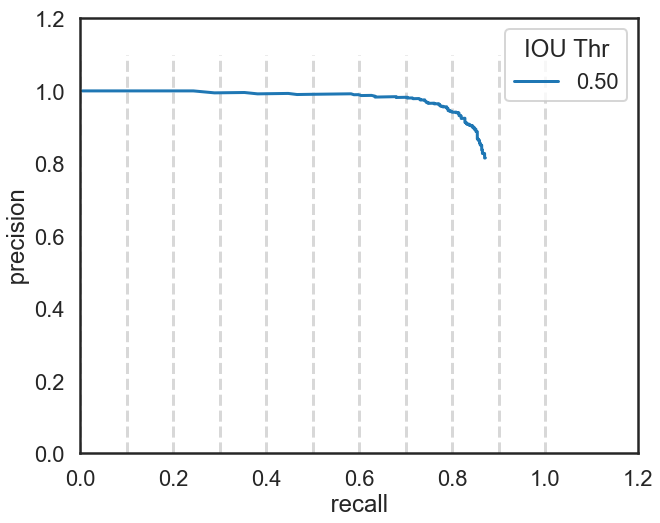

In [8]:
cls = 1

iou_thr = 0.5
start_time = time.time()
data =  cmap.get_avg_precision_at_iou(gt_boxes_class[cls], pr_boxes_class[cls], iou_thr=iou_thr, score_key = 'scores')
end_time = time.time()
print('Single IoU calculation took {:.4f} secs'.format(end_time - start_time))
print('avg precision: {:.4f}'.format(data['avg_prec']))
# pp.pprint(data)

idx = 0
ax = None
avg_precs = []
iou_thrs = []
avg_precs.append(data['avg_prec'])
iou_thrs.append(iou_thr)
precisions = data['precisions']
recalls    = data['recalls']
print(iou_thrs)
print(avg_precs)
print(' precisions: ', precisions.shape)
print(' recalls   : ', recalls.shape)
ax = cmap.plot_pr_curve(precisions, recalls, label='{:.2f}'.format(iou_thr), color=COLORS[idx*2], ax=ax)

avg_precs = [float('{:.4f}'.format(ap)) for ap in avg_precs]
iou_thrs = [float('{:.4f}'.format(thr)) for thr in iou_thrs]
print('map: {:.2f}'.format(100*np.mean(avg_precs)))
print('avg precs: ', avg_precs)
print('iou_thrs:  ', iou_thrs)
plt.legend(loc='upper right', title='IOU Thr', frameon=True)
for xval in np.linspace(0.0, 1.0, 11):
    plt.vlines(xval, 0.0, 1.1, color='gray', alpha=0.3, linestyles='dashed')
end_time = time.time()
print('\nPlotting and calculating mAP takes {:.4f} secs'.format(end_time - start_time))
plt.show()

### Display mAP one threshold (across all classes)

In [ ]:
cls = 1

iou_thr = 0.5
start_time = time.time()
data =  cmap.get_avg_precision_at_iou(gt_boxes, pr_boxes, iou_thr=iou_thr, score_key = 'scores')
end_time = time.time()
print('Single IoU calculation took {:.4f} secs'.format(end_time - start_time))
print('avg precision: {:.4f}'.format(data['avg_prec']))
# pp.pprint(data)

idx = 0
ax = None
avg_precs = []
iou_thrs = []
avg_precs.append(data['avg_prec'])
iou_thrs.append(iou_thr)
precisions = data['precisions']
recalls    = data['recalls']
print(iou_thrs)
print(avg_precs)
print(' precisions: ', precisions.shape)
print(' recalls   : ', recalls.shape)
ax = cmap.plot_pr_curve(precisions, recalls, label='{:.2f}'.format(iou_thr), color=COLORS[idx*2], ax=ax)

avg_precs = [float('{:.4f}'.format(ap)) for ap in avg_precs]
iou_thrs = [float('{:.4f}'.format(thr)) for thr in iou_thrs]
print('map: {:.2f}'.format(100*np.mean(avg_precs)))
print('avg precs: ', avg_precs)
print('iou_thrs:  ', iou_thrs)
plt.legend(loc='upper right', title='IOU Thr', frameon=True)
for xval in np.linspace(0.0, 1.0, 11):
    plt.vlines(xval, 0.0, 1.1, color='gray', alpha=0.3, linestyles='dashed')
end_time = time.time()
print('\nPlotting and calculating mAP takes {:.4f} secs'.format(end_time - start_time))
plt.show()

## Build Average Precision Data Structure for all class ids we are interested in 
Using loaded gt_boxes and pr_boxes.
    ALL_DATA is a dictionary keyed by class_id to dictionaries, one for each possible score. Each SCORE dictionary is itrself a dictionary with keys for iOUs 
    between 0.5 and 0.95. Each dictionary entry has the following keys:
    {'iou', 'model_thrs', 'recalls', 'precisions', 'avg_prec'}
    iou :         indicates the iOU threshold of the dictionary entry
    model_thrs:   score thresholds
    recalls   :   recall at threshold
    precision :   precision at threshold

In [177]:
# del all_data
class_ids = [1,2,3,4,5,6]
scores    = [ 'mrcnn_score_orig', 'mrcnn_score_norm', 'mrcnn_score_0', 'mrcnn_score_1', 'mrcnn_score_2', 'fcn_score_0', 'fcn_score_1', 'fcn_score_2']
all_data = {}
all_data = cmap.build_mAP_data_structure_by_class(gt_boxes_class, pr_boxes_class, class_ids, scores)

Build mAP information for classes:  [1, 2, 3, 4, 5, 6]  and scores  ['mrcnn_score_orig', 'mrcnn_score_norm', 'mrcnn_score_0', 'mrcnn_score_1', 'mrcnn_score_2', 'fcn_score_0', 'fcn_score_1', 'fcn_score_2']
class_id:   1   idx  0   iou_thr: 0.50  score_key: mrcnn_score_orig    
class_id:   1   idx  1   iou_thr: 0.55  score_key: mrcnn_score_orig    
class_id:   1   idx  2   iou_thr: 0.60  score_key: mrcnn_score_orig    
class_id:   1   idx  3   iou_thr: 0.65  score_key: mrcnn_score_orig    
class_id:   1   idx  4   iou_thr: 0.70  score_key: mrcnn_score_orig    
class_id:   1   idx  5   iou_thr: 0.75  score_key: mrcnn_score_orig    
class_id:   1   idx  6   iou_thr: 0.80  score_key: mrcnn_score_orig    
class_id:   1   idx  7   iou_thr: 0.85  score_key: mrcnn_score_orig    
class_id:   1   idx  8   iou_thr: 0.90  score_key: mrcnn_score_orig    
class_id:   1   idx  0   iou_thr: 0.50  score_key: mrcnn_score_norm    
class_id:   1   idx  1   iou_thr: 0.55  score_key: mrcnn_score_norm    
cla

class_id:   2   idx  3   iou_thr: 0.65  score_key: mrcnn_score_2       
class_id:   2   idx  4   iou_thr: 0.70  score_key: mrcnn_score_2       
class_id:   2   idx  5   iou_thr: 0.75  score_key: mrcnn_score_2       
class_id:   2   idx  6   iou_thr: 0.80  score_key: mrcnn_score_2       
class_id:   2   idx  7   iou_thr: 0.85  score_key: mrcnn_score_2       
class_id:   2   idx  8   iou_thr: 0.90  score_key: mrcnn_score_2       
class_id:   2   idx  0   iou_thr: 0.50  score_key: fcn_score_0         
class_id:   2   idx  1   iou_thr: 0.55  score_key: fcn_score_0         
class_id:   2   idx  2   iou_thr: 0.60  score_key: fcn_score_0         
class_id:   2   idx  3   iou_thr: 0.65  score_key: fcn_score_0         
class_id:   2   idx  4   iou_thr: 0.70  score_key: fcn_score_0         
class_id:   2   idx  5   iou_thr: 0.75  score_key: fcn_score_0         
class_id:   2   idx  6   iou_thr: 0.80  score_key: fcn_score_0         
class_id:   2   idx  7   iou_thr: 0.85  score_key: fcn_score_0  

class_id:   4   idx  1   iou_thr: 0.55  score_key: mrcnn_score_norm    
class_id:   4   idx  2   iou_thr: 0.60  score_key: mrcnn_score_norm    
class_id:   4   idx  3   iou_thr: 0.65  score_key: mrcnn_score_norm    
class_id:   4   idx  4   iou_thr: 0.70  score_key: mrcnn_score_norm    
class_id:   4   idx  5   iou_thr: 0.75  score_key: mrcnn_score_norm    
class_id:   4   idx  6   iou_thr: 0.80  score_key: mrcnn_score_norm    
class_id:   4   idx  7   iou_thr: 0.85  score_key: mrcnn_score_norm    
class_id:   4   idx  8   iou_thr: 0.90  score_key: mrcnn_score_norm    
class_id:   4   idx  0   iou_thr: 0.50  score_key: mrcnn_score_0       
class_id:   4   idx  1   iou_thr: 0.55  score_key: mrcnn_score_0       
class_id:   4   idx  2   iou_thr: 0.60  score_key: mrcnn_score_0       
class_id:   4   idx  3   iou_thr: 0.65  score_key: mrcnn_score_0       
class_id:   4   idx  4   iou_thr: 0.70  score_key: mrcnn_score_0       
class_id:   4   idx  5   iou_thr: 0.75  score_key: mrcnn_score_0

class_id:   5   idx  8   iou_thr: 0.90  score_key: fcn_score_0         
class_id:   5   idx  0   iou_thr: 0.50  score_key: fcn_score_1         
class_id:   5   idx  1   iou_thr: 0.55  score_key: fcn_score_1         
class_id:   5   idx  2   iou_thr: 0.60  score_key: fcn_score_1         
class_id:   5   idx  3   iou_thr: 0.65  score_key: fcn_score_1         
class_id:   5   idx  4   iou_thr: 0.70  score_key: fcn_score_1         
class_id:   5   idx  5   iou_thr: 0.75  score_key: fcn_score_1         
class_id:   5   idx  6   iou_thr: 0.80  score_key: fcn_score_1         
class_id:   5   idx  7   iou_thr: 0.85  score_key: fcn_score_1         
class_id:   5   idx  8   iou_thr: 0.90  score_key: fcn_score_1         
class_id:   5   idx  0   iou_thr: 0.50  score_key: fcn_score_2         
class_id:   5   idx  1   iou_thr: 0.55  score_key: fcn_score_2         
class_id:   5   idx  2   iou_thr: 0.60  score_key: fcn_score_2         
class_id:   5   idx  3   iou_thr: 0.65  score_key: fcn_score_2  

In [180]:
print(all_data.keys())

dict_keys([0, 1, 2, 3, 4, 5, 6])


In [179]:
# combined_data = build_mAP_data_structure_combined(gt_boxes, pr_boxes, scores)
all_data[0] = cmap.build_mAP_data_structure_combined(gt_boxes, pr_boxes, scores)

Build mAP (all classes combined)  
 For scores:  ['mrcnn_score_orig', 'mrcnn_score_norm', 'mrcnn_score_0', 'mrcnn_score_1', 'mrcnn_score_2', 'fcn_score_0', 'fcn_score_1', 'fcn_score_2']
 score_key: mrcnn_score_orig     
 score_key: mrcnn_score_norm     
 score_key: mrcnn_score_0        
 score_key: mrcnn_score_1        
 score_key: mrcnn_score_2        
 score_key: fcn_score_0          
 score_key: fcn_score_1          
 score_key: fcn_score_2          


In [183]:
# path = "E:\\git_projs\\MRCNN3\\train_coco"
epoch = '2017'
path = "E:\\git_projs\\MRCNN3\\train_newshapes\\training_results"
map_info_file = 'test_map_info_epoch'+epoch+'.pkl'
with open(os.path.join(path, map_info_file), 'wb') as outfile:
    pickle.dump(all_data, outfile)            


In [184]:
print(all_data.keys())
print(all_data[1].keys())
print(all_data[1]['mrcnn_score_2'].keys())
print(all_data[1]['mrcnn_score_2'][0.5].keys())

dict_keys([0, 1, 2, 3, 4, 5, 6])
dict_keys(['mrcnn_score_orig', 'mrcnn_score_1', 'fcn_score_0', 'fcn_score_2', 'fcn_score_1', 'mrcnn_score_2', 'mrcnn_score_0', 'mrcnn_score_norm'])
dict_keys([0.5, 0.55, 0.85, 0.6, 0.8, 0.7, 0.9, 0.65, 0.75])
dict_keys(['model_thrs', 'avg_prec', 'prec_at_rec', 'recalls', 'iou', 'precisions'])


In [185]:
score_key = 'mrcnn_score_0'
print(all_data.keys())
print(all_data[0].keys())
print(all_data[0][score_key].keys())
print(all_data[0][score_key][0.5].keys())
print(' iou             : ', all_data[0][score_key][0.5]['iou'])
print(' score_thresholds: ', len(all_data[0][score_key][0.5]['model_thrs']))
print(' precisions      : ', len(all_data[0][score_key][0.5]['precisions']))
print(' recalls         : ', len(all_data[0][score_key][0.5]['recalls']))
print(' prec_at_rec     : ', len(all_data[0][score_key][0.5]['prec_at_rec']))
print(' prec_at_rec     : ', all_data[0][score_key][0.5]['prec_at_rec'])

dict_keys([0, 1, 2, 3, 4, 5, 6])
dict_keys(['mrcnn_score_orig', 'mrcnn_score_1', 'fcn_score_0', 'fcn_score_2', 'fcn_score_1', 'mrcnn_score_2', 'mrcnn_score_0', 'mrcnn_score_norm'])
dict_keys([0.5, 0.55, 0.85, 0.6, 0.8, 0.7, 0.9, 0.65, 0.75])
dict_keys(['model_thrs', 'avg_prec', 'prec_at_rec', 'recalls', 'iou', 'precisions'])
 iou             :  0.5
 score_thresholds:  870
 precisions      :  870
 recalls         :  870
 prec_at_rec     :  11
 prec_at_rec     :  [0.9923857868020305, 0.9923857868020305, 0.9889042995839112, 0.9858333333333333, 0.9844961240310077, 0.981360201511335, 0.9802664035520473, 0.9737954353338969, 0.9680029422581832, 0.9559105431309904, 0.0]


In [ ]:
# for lst in all_data[1]:
#     print(lst)
#     print(all_data[1][lst])
# #     ['iou'], lst['avg_prec'])
#     print(len(all_data[1][lst]['model_thrs']), len(all_data[1][lst]['precisions']), len(all_data[1][lst]['recalls']))

### Plot AP vs. IoU Threshold for various scores 

 Num disp classes 1  Columns:  1  Rows:  1


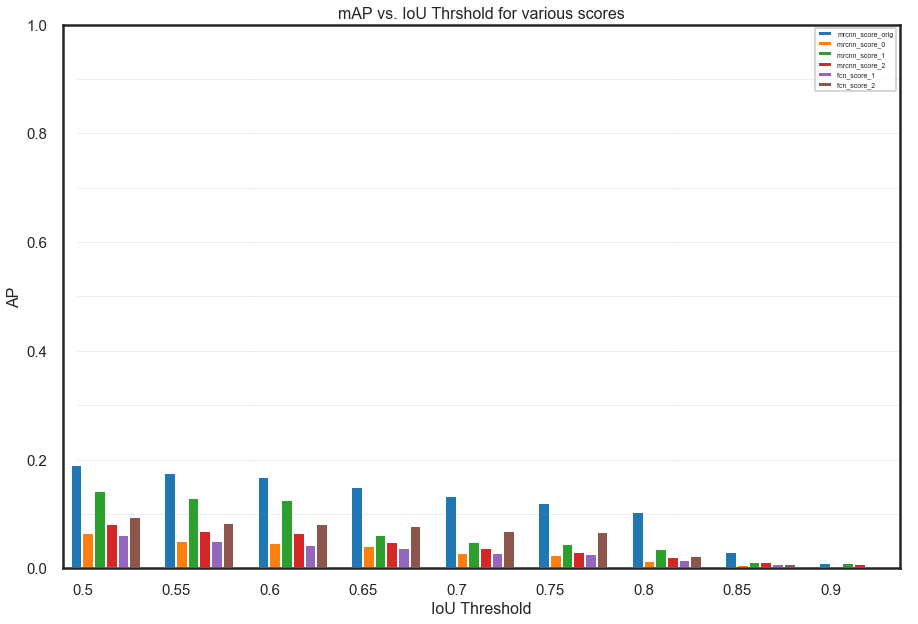


                                                  AP @ IoU Thresholds for computed scores                                                   

-------------------------------------------------------------  IoU Thresholds  -------------------------------------------------------------
Score -                           0.5000     0.5500     0.6000     0.6500     0.7000     0.7500     0.8000     0.8500     0.9000       mAP
--------------------------------------------------------------------------------------------------------------------------------------------
mrcnn_score_orig                  0.1907     0.1748     0.1675     0.1497     0.1330     0.1200     0.1034     0.0299     0.0091     %11.98 
mrcnn_score_0                     0.0649     0.0510     0.0462     0.0411     0.0287     0.0238     0.0126     0.0060     0.0014     %3.06 
mrcnn_score_1                     0.1428     0.1297     0.1255     0.0607     0.0491     0.0452     0.0363     0.0125     0.0091     %6.79 
mrcnn_score_2  

In [13]:
# disp_scores  = [ 'mrcnn_score_orig' , 'mrcnn_score_norm', 'mrcnn_score_0', 'mrcnn_score_1', 'mrcnn_score_2', 'fcn_score_0', 'fcn_score_1', 'fcn_score_2']
disp_scores  = [ 'mrcnn_score_orig' , 'mrcnn_score_0', 'mrcnn_score_1', 'mrcnn_score_2', 'fcn_score_1', 'fcn_score_2']
cmap.plot_mAP_vs_IoUs_BarChart(all_data, disp_scores)

## Plot combined mAP for different IoU thresholds for each score
(one type of score, e.g. 'scores' - all classes combined)

['ALL CLASSES', 'person', 'car', 'sun', 'building', 'tree', 'cloud']

                                         AP @ IoU Thresholds for Score Computation: mrcnn_score_orig                                        

-------------------------------------------------------------  IoU Thresholds  -------------------------------------------------------------
Id - ClassName                    0.5000     0.5500     0.6000     0.6500     0.7000     0.7500     0.8000     0.8500     0.9000       mAP
--------------------------------------------------------------------------------------------------------------------------------------------
  0 - ALL CLASSES                 0.9054     0.9023     0.8921     0.7962     0.7721     0.6545     0.5047     0.2586     0.0795      %64.06 



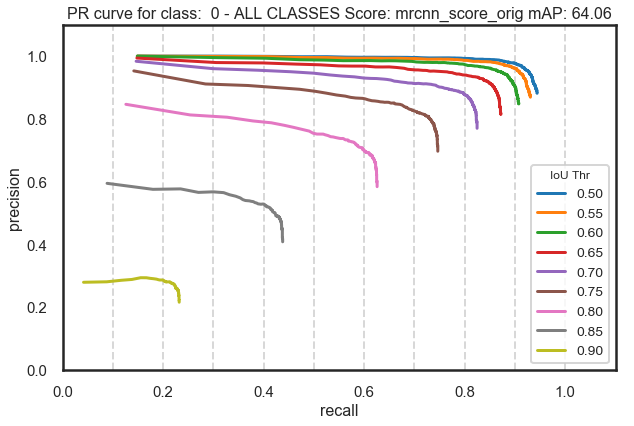

In [56]:
# plot_mAP_by_score(all_data, 'scores' )

cmap.plot_mAP_by_IOU(all_data, 'mrcnn_score_orig' , class_ids = 0 , class_names = class_names, columns = 3)

['ALL CLASSES', 'person', 'car', 'sun', 'building', 'tree', 'cloud']

                                          AP @ IoU Thresholds for Score Computation: mrcnn_score_0                                          

-------------------------------------------------------------  IoU Thresholds  -------------------------------------------------------------
Id - ClassName                    0.5000     0.5500     0.6000     0.6500     0.7000     0.7500     0.8000     0.8500     0.9000       mAP
--------------------------------------------------------------------------------------------------------------------------------------------
  0 - ALL CLASSES                 0.8912     0.8870     0.8770     0.7862     0.7696     0.6493     0.5006     0.2566     0.0779      %63.28 



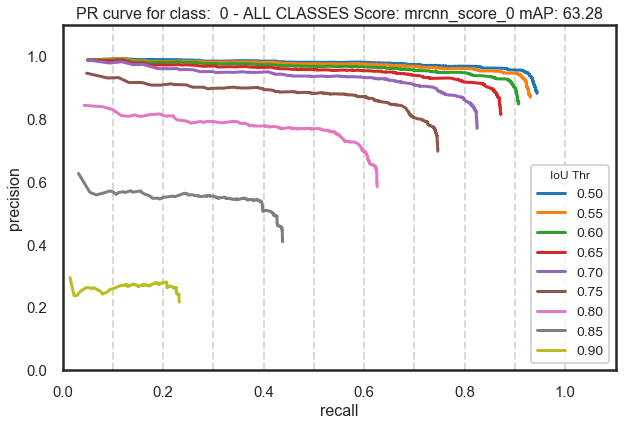

In [65]:
# plot_mAP_by_score(all_data, 'scores' )

cmap.plot_mAP_by_IOU(all_data, 'mrcnn_score_0' , class_ids = 0 , class_names = class_names, columns = 3)

['ALL CLASSES', 'person', 'car', 'sun', 'building', 'tree', 'cloud']

                                          AP @ IoU Thresholds for Score Computation: mrcnn_score_1                                          

-------------------------------------------------------------  IoU Thresholds  -------------------------------------------------------------
Id - ClassName                    0.5000     0.5500     0.6000     0.6500     0.7000     0.7500     0.8000     0.8500     0.9000       mAP
--------------------------------------------------------------------------------------------------------------------------------------------
  0 - ALL CLASSES                 0.8872     0.8809     0.8691     0.7714     0.7501     0.6297     0.4866     0.2769     0.1380      %63.22 



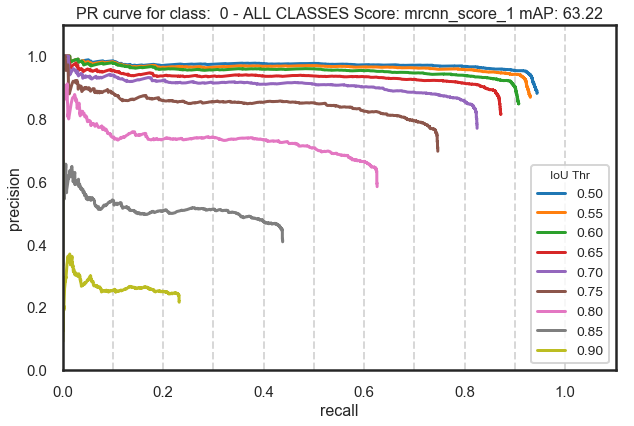

In [57]:
# plot_mAP_by_score(all_data, 'scores' )
cmap.plot_mAP_by_IOU(all_data, 'mrcnn_score_1' , class_ids = 0 ,class_names = class_names, columns = 3)

['ALL CLASSES', 'person', 'car', 'sun', 'building', 'tree', 'cloud']

                                          AP @ IoU Thresholds for Score Computation: mrcnn_score_2                                          

-------------------------------------------------------------  IoU Thresholds  -------------------------------------------------------------
Id - ClassName                    0.5000     0.5500     0.6000     0.6500     0.7000     0.7500     0.8000     0.8500     0.9000       mAP
--------------------------------------------------------------------------------------------------------------------------------------------
  0 - ALL CLASSES                 0.8873     0.8806     0.8687     0.7709     0.7497     0.6299     0.4868     0.2767     0.1380      %63.21 



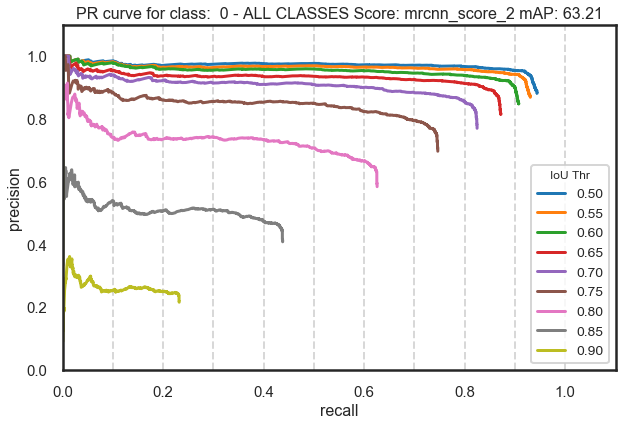

In [58]:
# plot_mAP_by_score(all_data, 'scores' )
cmap.plot_mAP_by_IOU(all_data, 'mrcnn_score_2' , class_ids = 0 ,class_names = class_names, columns = 3)

['ALL CLASSES', 'person', 'car', 'sun', 'building', 'tree', 'cloud']

                                         AP @ IoU Thresholds for Score Computation: mrcnn_score_norm                                        

-------------------------------------------------------------  IoU Thresholds  -------------------------------------------------------------
Id - ClassName                    0.5000     0.5500     0.6000     0.6500     0.7000     0.7500     0.8000     0.8500     0.9000       mAP
--------------------------------------------------------------------------------------------------------------------------------------------
  0 - ALL CLASSES                 0.8933     0.8852     0.8682     0.7647     0.7317     0.5997     0.4516     0.2335     0.0742      %61.13 



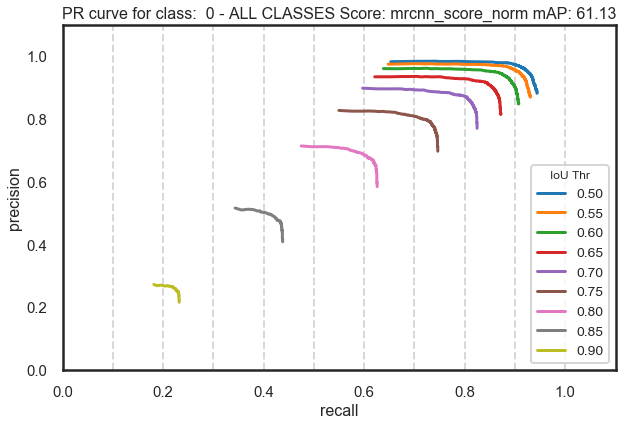

In [59]:
# plot_mAP_by_score(all_data, 'scores' )
cmap.plot_mAP_by_IOU(all_data, 'mrcnn_score_norm' , class_ids = 0 ,class_names = class_names, columns = 3)

['ALL CLASSES', 'person', 'car', 'sun', 'building', 'tree', 'cloud']

                                           AP @ IoU Thresholds for Score Computation: fcn_score_0                                           

-------------------------------------------------------------  IoU Thresholds  -------------------------------------------------------------
Id - ClassName                    0.5000     0.5500     0.6000     0.6500     0.7000     0.7500     0.8000     0.8500     0.9000       mAP
--------------------------------------------------------------------------------------------------------------------------------------------
  0 - ALL CLASSES                 0.8168     0.8037     0.7782     0.6695     0.6322     0.5085     0.3797     0.1880     0.0675      %53.82 



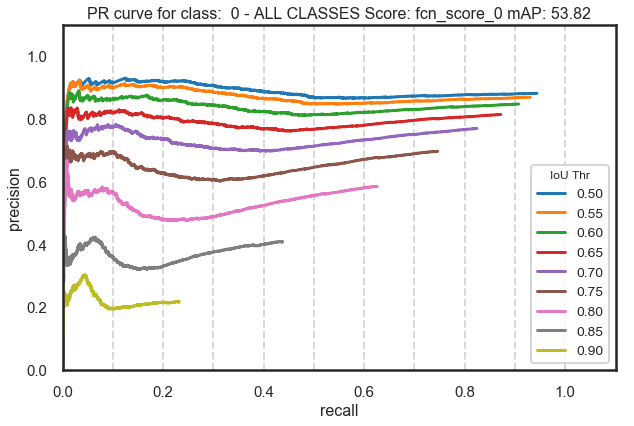

In [64]:
# plot_mAP_by_score(all_data, 'scores' )
cmap.plot_mAP_by_IOU(all_data, 'fcn_score_0' , class_ids = 0 , class_names = class_names,columns = 3)

['ALL CLASSES', 'person', 'car', 'sun', 'building', 'tree', 'cloud']

                                           AP @ IoU Thresholds for Score Computation: fcn_score_1                                           

-------------------------------------------------------------  IoU Thresholds  -------------------------------------------------------------
Id - ClassName                    0.5000     0.5500     0.6000     0.6500     0.7000     0.7500     0.8000     0.8500     0.9000       mAP
--------------------------------------------------------------------------------------------------------------------------------------------
  0 - ALL CLASSES                 0.8893     0.8852     0.8748     0.7860     0.7669     0.6517     0.5136     0.2763     0.0964      %63.78 



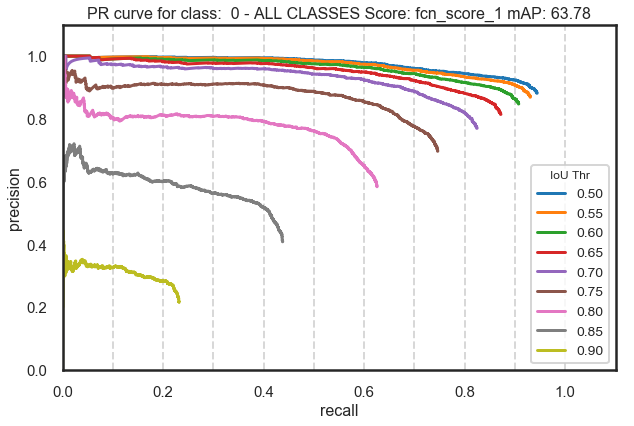

In [62]:
# plot_mAP_by_score(all_data, 'scores' )
cmap.plot_mAP_by_IOU(all_data, 'fcn_score_1' , class_ids = 0 , class_names = class_names,columns = 3)

['ALL CLASSES', 'person', 'car', 'sun', 'building', 'tree', 'cloud']

                                           AP @ IoU Thresholds for Score Computation: fcn_score_2                                           

-------------------------------------------------------------  IoU Thresholds  -------------------------------------------------------------
Id - ClassName                    0.5000     0.5500     0.6000     0.6500     0.7000     0.7500     0.8000     0.8500     0.9000       mAP
--------------------------------------------------------------------------------------------------------------------------------------------
  0 - ALL CLASSES                 0.8922     0.8857     0.8715     0.7749     0.7474     0.6266     0.4867     0.2858     0.1032      %63.04 



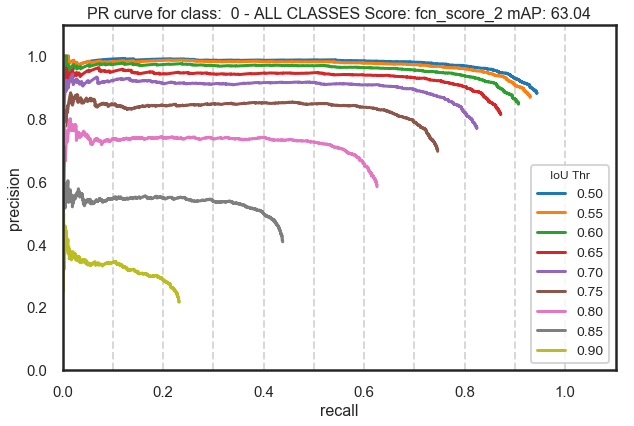

In [63]:
# plot_mAP_by_score(all_data, 'scores' )
cmap.plot_mAP_by_IOU(all_data, 'fcn_score_2' , class_ids = 0 , class_names = class_names,columns = 3)

## Plot combined mAP info for different scores (at a given IoU threshold, all classes combined)


                                                               AP @ IoU 0.80 Thresholds for Computed Scores                                                               

--------------------------------------------------------------------------------  scores  --------------------------------------------------------------------------------
Id - ClassName           mrcnn_score_orig  mrcnn_score_norm     mrcnn_score_0     mrcnn_score_1     mrcnn_score_2       fcn_score_0       fcn_score_1       fcn_score_2
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
mAP ALL CLASSES                    0.5047            0.4516            0.5006            0.4866            0.4868            0.3720            0.5

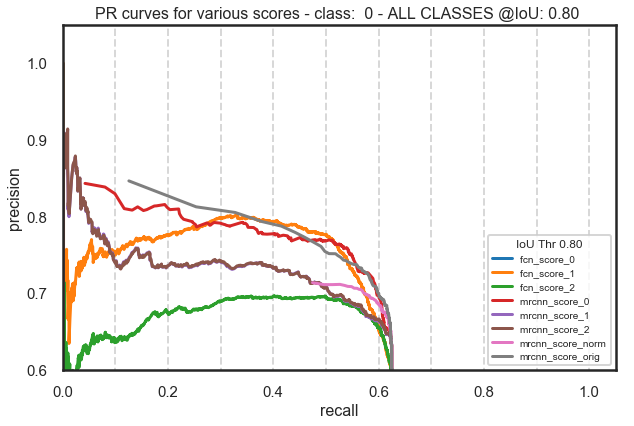

In [194]:
disp_scores  = [ 'mrcnn_score_orig' , 'mrcnn_score_norm', 'mrcnn_score_0', 'mrcnn_score_1', 'mrcnn_score_2' ,'fcn_score_0', 'fcn_score_1', 'fcn_score_2']
cmap.plot_mAP_by_scores(all_data, scores = disp_scores, class_ids = [0], class_names = class_names,iou = 0.80)


                                                               AP @ IoU 0.85 Thresholds for Computed Scores                                                               

--------------------------------------------------------------------------------  scores  --------------------------------------------------------------------------------
Id - ClassName           mrcnn_score_orig  mrcnn_score_norm     mrcnn_score_0     mrcnn_score_1       fcn_score_0       fcn_score_1       fcn_score_2
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
mAP ALL CLASSES                    0.2586            0.2335            0.2566            0.2769            0.1860            0.2951            0.2758 
-------------

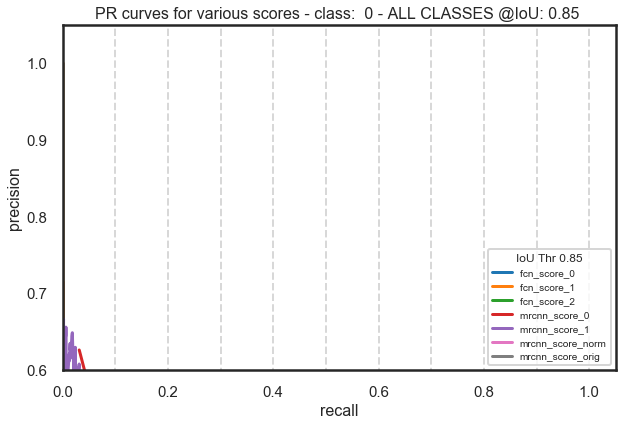

In [195]:
disp_scores  = [ 'mrcnn_score_orig' , 'mrcnn_score_norm', 'mrcnn_score_0', 'mrcnn_score_1',  'fcn_score_0', 'fcn_score_1', 'fcn_score_2']
cmap.plot_mAP_by_scores(all_data, scores = disp_scores, class_ids = [0], class_names = class_names, iou = 0.85)


                                                               AP @ IoU 0.75 Thresholds for Computed Scores                                                               

--------------------------------------------------------------------------------  scores  --------------------------------------------------------------------------------
Id - ClassName           mrcnn_score_orig  mrcnn_score_norm     mrcnn_score_0     mrcnn_score_1       fcn_score_0       fcn_score_1       fcn_score_2
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
mAP ALL CLASSES                    0.6545            0.5997            0.6493            0.6297            0.5069            0.6488            0.6058 
-------------

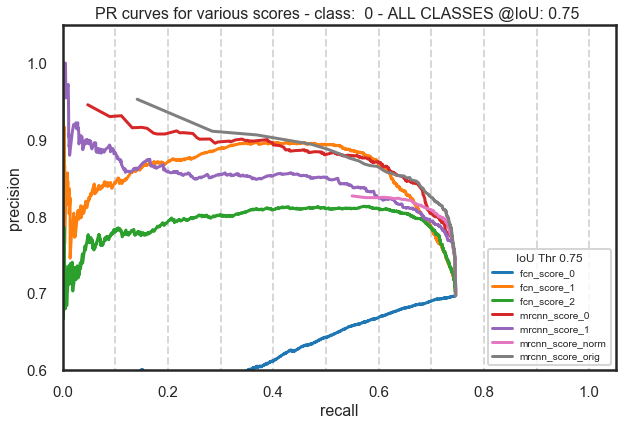

In [211]:
disp_scores  = [ 'mrcnn_score_orig' , 'mrcnn_score_norm', 'mrcnn_score_0', 'mrcnn_score_1',  'fcn_score_0', 'fcn_score_1', 'fcn_score_2']
cmap.plot_mAP_by_scores(all_data, scores = disp_scores, class_ids = [0], class_names = class_names, iou = 0.75)

## Indvidual classes - Plot mAP info for  at different thresholds (one type of score, e.g. 'scores')

### Plot mAP for `mrcnn_score_orig`

['ALL CLASSES', 'person', 'car', 'sun', 'building', 'tree', 'cloud']

                                         AP @ IoU Thresholds for Score Computation: mrcnn_score_orig                                        

-------------------------------------------------------------  IoU Thresholds  -------------------------------------------------------------
Id - ClassName                    0.5000     0.5500     0.6000     0.6500     0.7000     0.7500     0.8000     0.8500     0.9000       mAP
--------------------------------------------------------------------------------------------------------------------------------------------
  0 - ALL CLASSES                 0.9054     0.9023     0.8921     0.7962     0.7721     0.6545     0.5047     0.2586     0.0795      %64.06 
  1 - person                      0.8084     0.7965     0.6878     0.5307     0.3618     0.1987     0.0708     0.0283     0.0069      %38.78 
  2 - car                         0.9082     0.9066     0.9024     0.8885     0.785

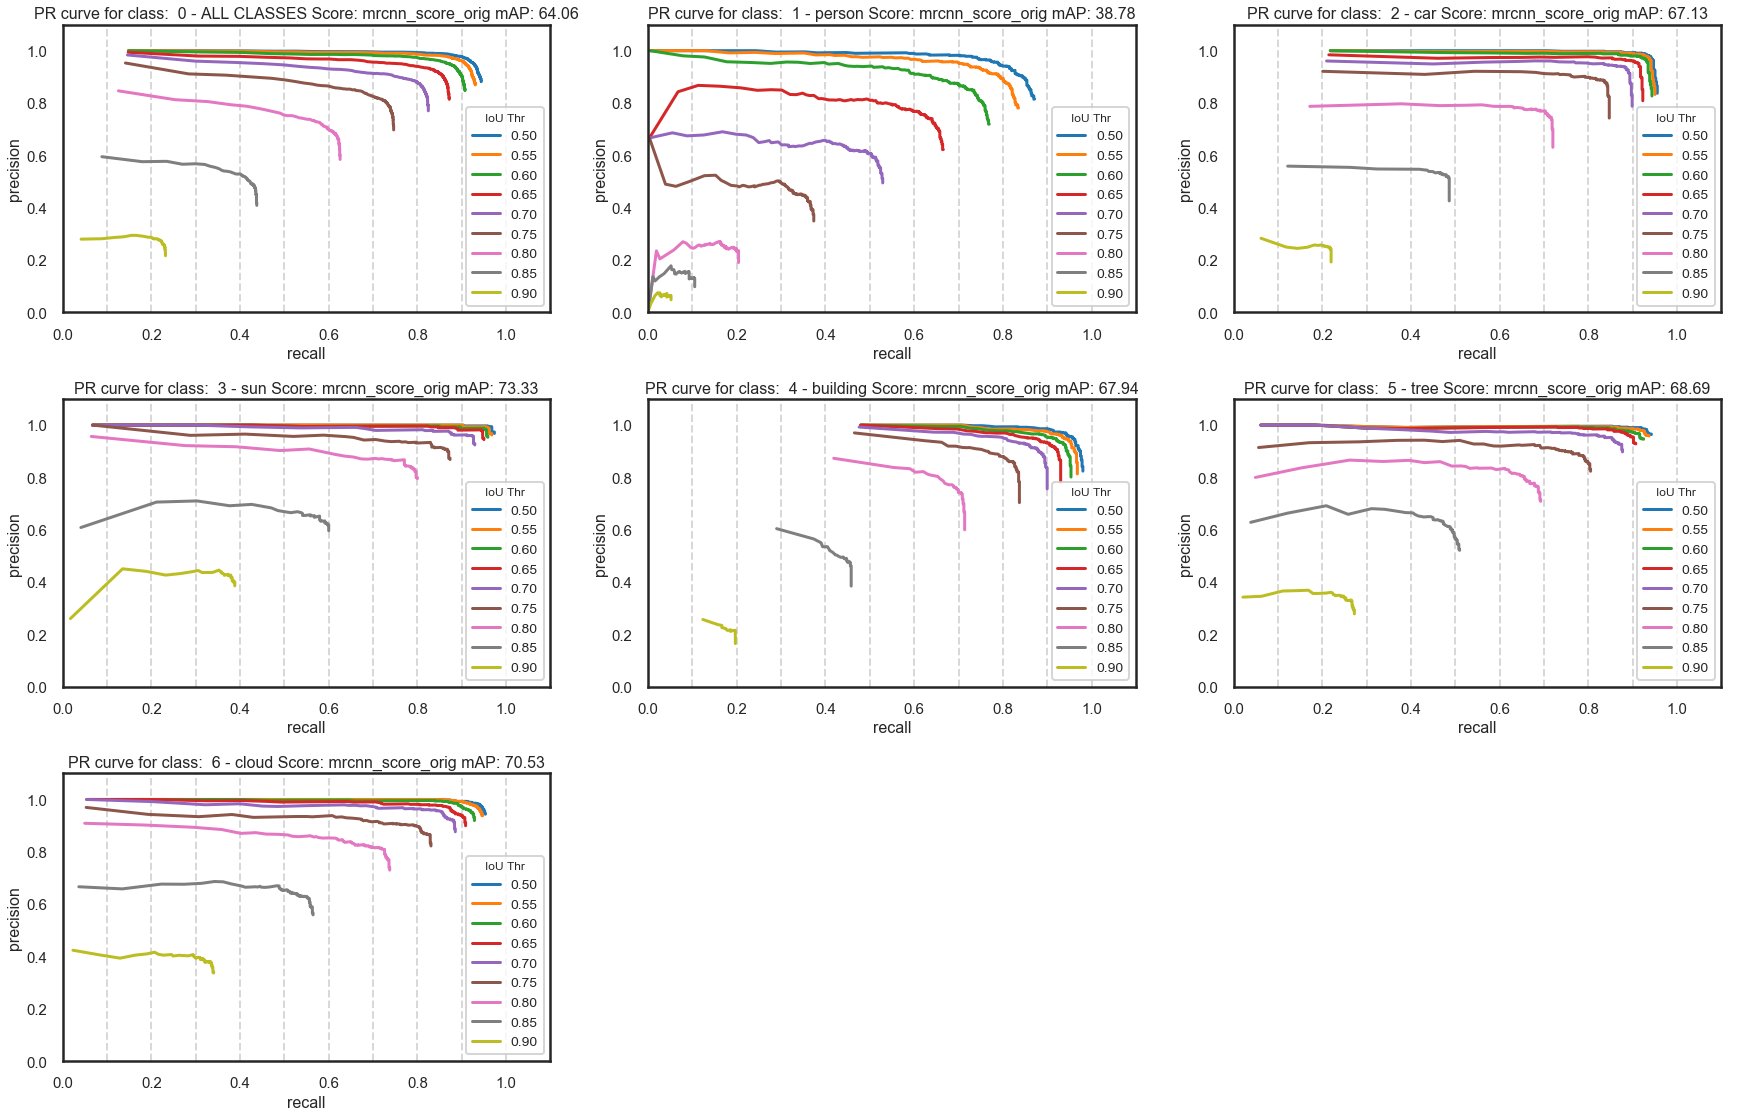

In [199]:
# plot_mAP_by_score(all_data, 'scores' )
cmap.plot_mAP_by_IOU(all_data, 'mrcnn_score_orig', class_names = class_names )

### Plot mAP for `mrcnn_score_norm`


                                         AP @ IoU Thresholds for Score Computation: mrcnn_score_norm                                        

-------------------------------------------------------------  IoU Thresholds  -------------------------------------------------------------
Id - ClassName                    0.5000     0.5500     0.6000     0.6500     0.7000     0.7500     0.8000     0.8500     0.9000       mAP
--------------------------------------------------------------------------------------------------------------------------------------------
  1 - person                      0.7777     0.7569     0.6442     0.4946     0.3545     0.1565     0.0654     0.0264     0.0050      %36.46 
  2 - car                         0.8921     0.8852     0.8817     0.8759     0.7737     0.7111     0.4763     0.2429     0.0719      %64.56 
  3 - sun                         0.9062     0.9062     0.8977     0.8919     0.8634     0.8205     0.5786     0.3862     0.1338      %70.94 
  4 - buil

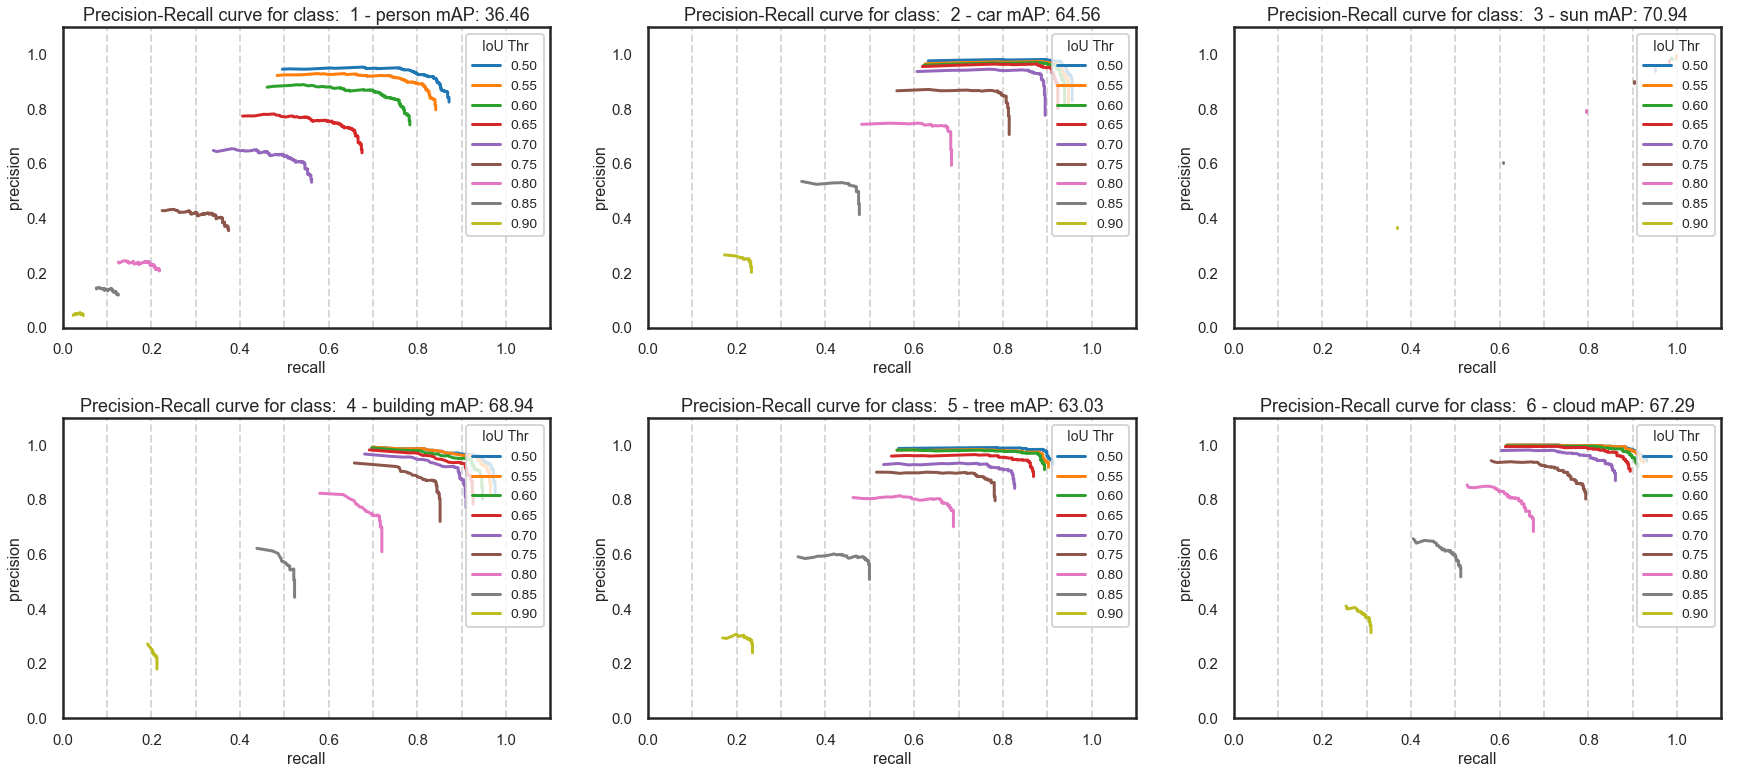

In [163]:
plot_mAP_by_IOU(all_data, 'mrcnn_score_norm')

### Plot mAP for `mrcnn_score_0`

['ALL CLASSES', 'person', 'car', 'sun', 'building', 'tree', 'cloud']

                                          AP @ IoU Thresholds for Score Computation: mrcnn_score_0                                          

-------------------------------------------------------------  IoU Thresholds  -------------------------------------------------------------
Id - ClassName                    0.5000     0.5500     0.6000     0.6500     0.7000     0.7500     0.8000     0.8500     0.9000       mAP
--------------------------------------------------------------------------------------------------------------------------------------------
  0 - ALL CLASSES                 0.8912     0.8870     0.8770     0.7862     0.7696     0.6493     0.5006     0.2566     0.0779      %63.28 
  1 - person                      0.7774     0.7507     0.6410     0.5154     0.3580     0.1734     0.0717     0.0244     0.0061      %36.87 
  2 - car                         0.8851     0.8819     0.8780     0.8694     0.766

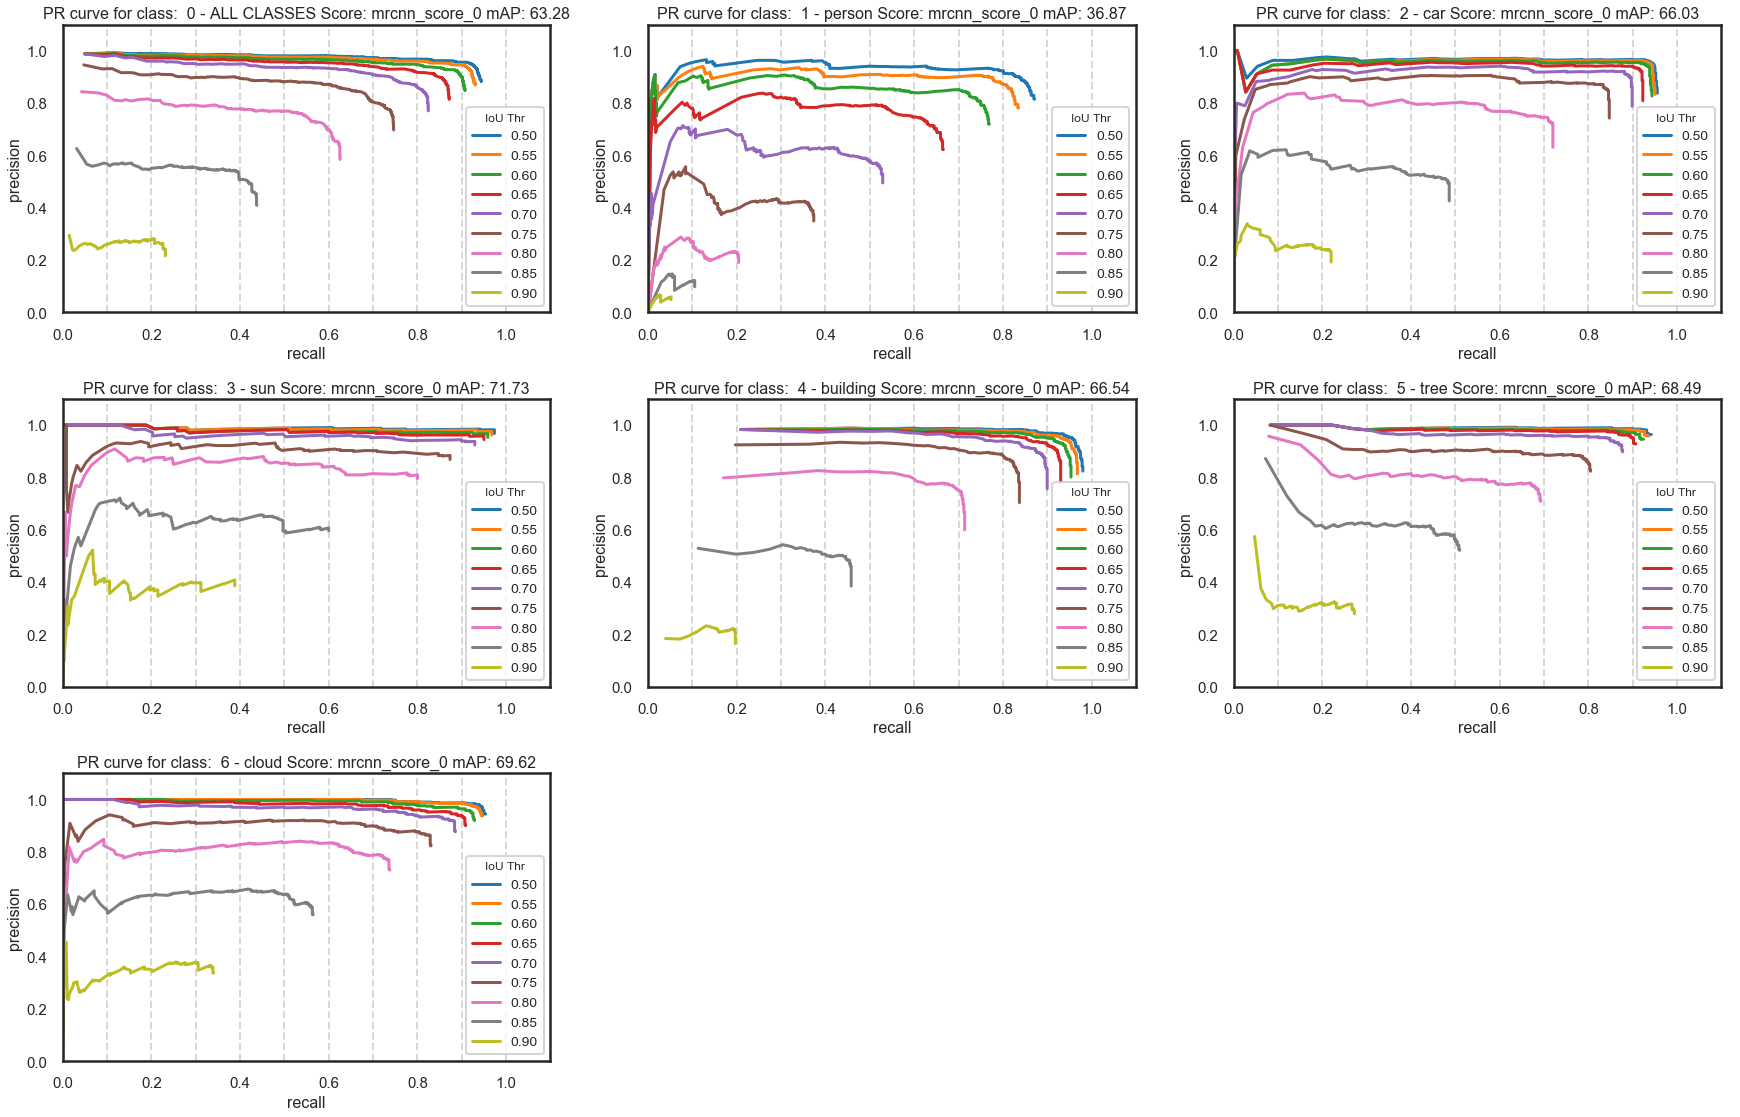

In [201]:
cmap.plot_mAP_by_IOU(all_data, 'mrcnn_score_0', class_names = class_names )

### Plot mAP for `mrcnn_score_1`


                                          AP @ IoU Thresholds for Score Computation: mrcnn_score_1                                          

-------------------------------------------------------------  IoU Thresholds  -------------------------------------------------------------
Id - ClassName                    0.5000     0.5500     0.6000     0.6500     0.7000     0.7500     0.8000     0.8500     0.9000       mAP
--------------------------------------------------------------------------------------------------------------------------------------------
  1 - person                      0.7681     0.7508     0.6414     0.5258     0.3946     0.2080     0.0874     0.0242     0.0046      %37.83 
  2 - car                         0.8868     0.8802     0.8774     0.8688     0.7643     0.7040     0.4714     0.2573     0.0846      %64.39 
  3 - sun                         0.9079     0.9079     0.9018     0.8996     0.8708     0.8420     0.6106     0.4377     0.1617      %72.67 
  4 - buil

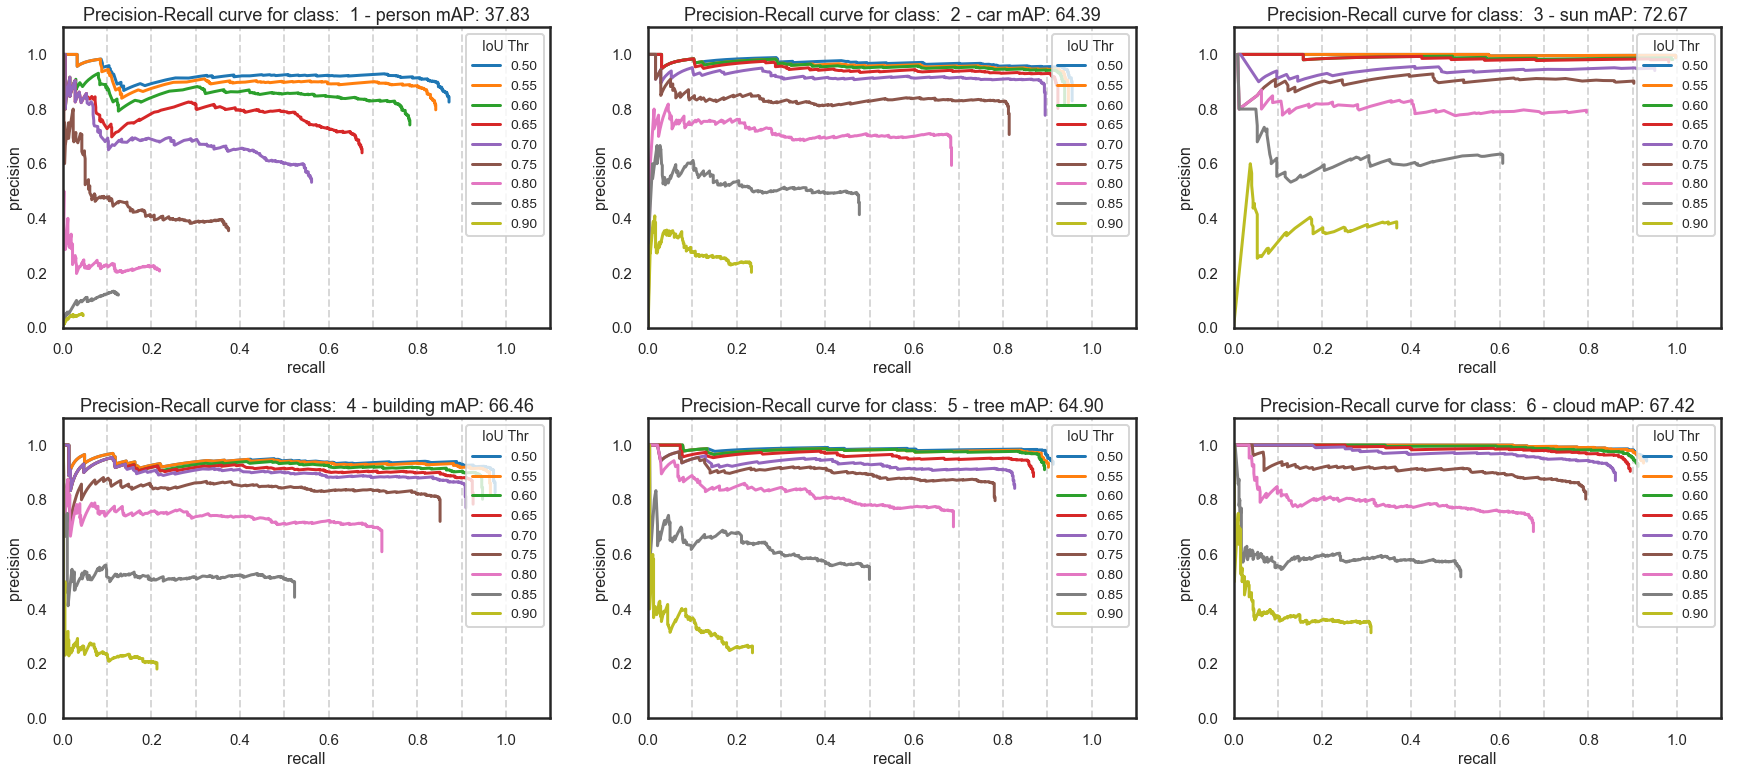

In [165]:
plot_mAP_by_IOU(all_data, 'mrcnn_score_1', class_names = class_names )

### Plot mAP for `mrcnn_score_2`

['ALL CLASSES', 'person', 'car', 'sun', 'building', 'tree', 'cloud']

                                          AP @ IoU Thresholds for Score Computation: mrcnn_score_2                                          

-------------------------------------------------------------  IoU Thresholds  -------------------------------------------------------------
Id - ClassName                    0.5000     0.5500     0.6000     0.6500     0.7000     0.7500     0.8000     0.8500     0.9000       mAP
--------------------------------------------------------------------------------------------------------------------------------------------
  0 - ALL CLASSES                 0.8873     0.8806     0.8687     0.7709     0.7497     0.6299     0.4868     0.2767     0.1380      %63.21 
  1 - person                      0.7785     0.7521     0.6368     0.5174     0.3795     0.2199     0.0855     0.0212     0.0053      %37.74 
  2 - car                         0.8771     0.8738     0.8714     0.8576     0.751

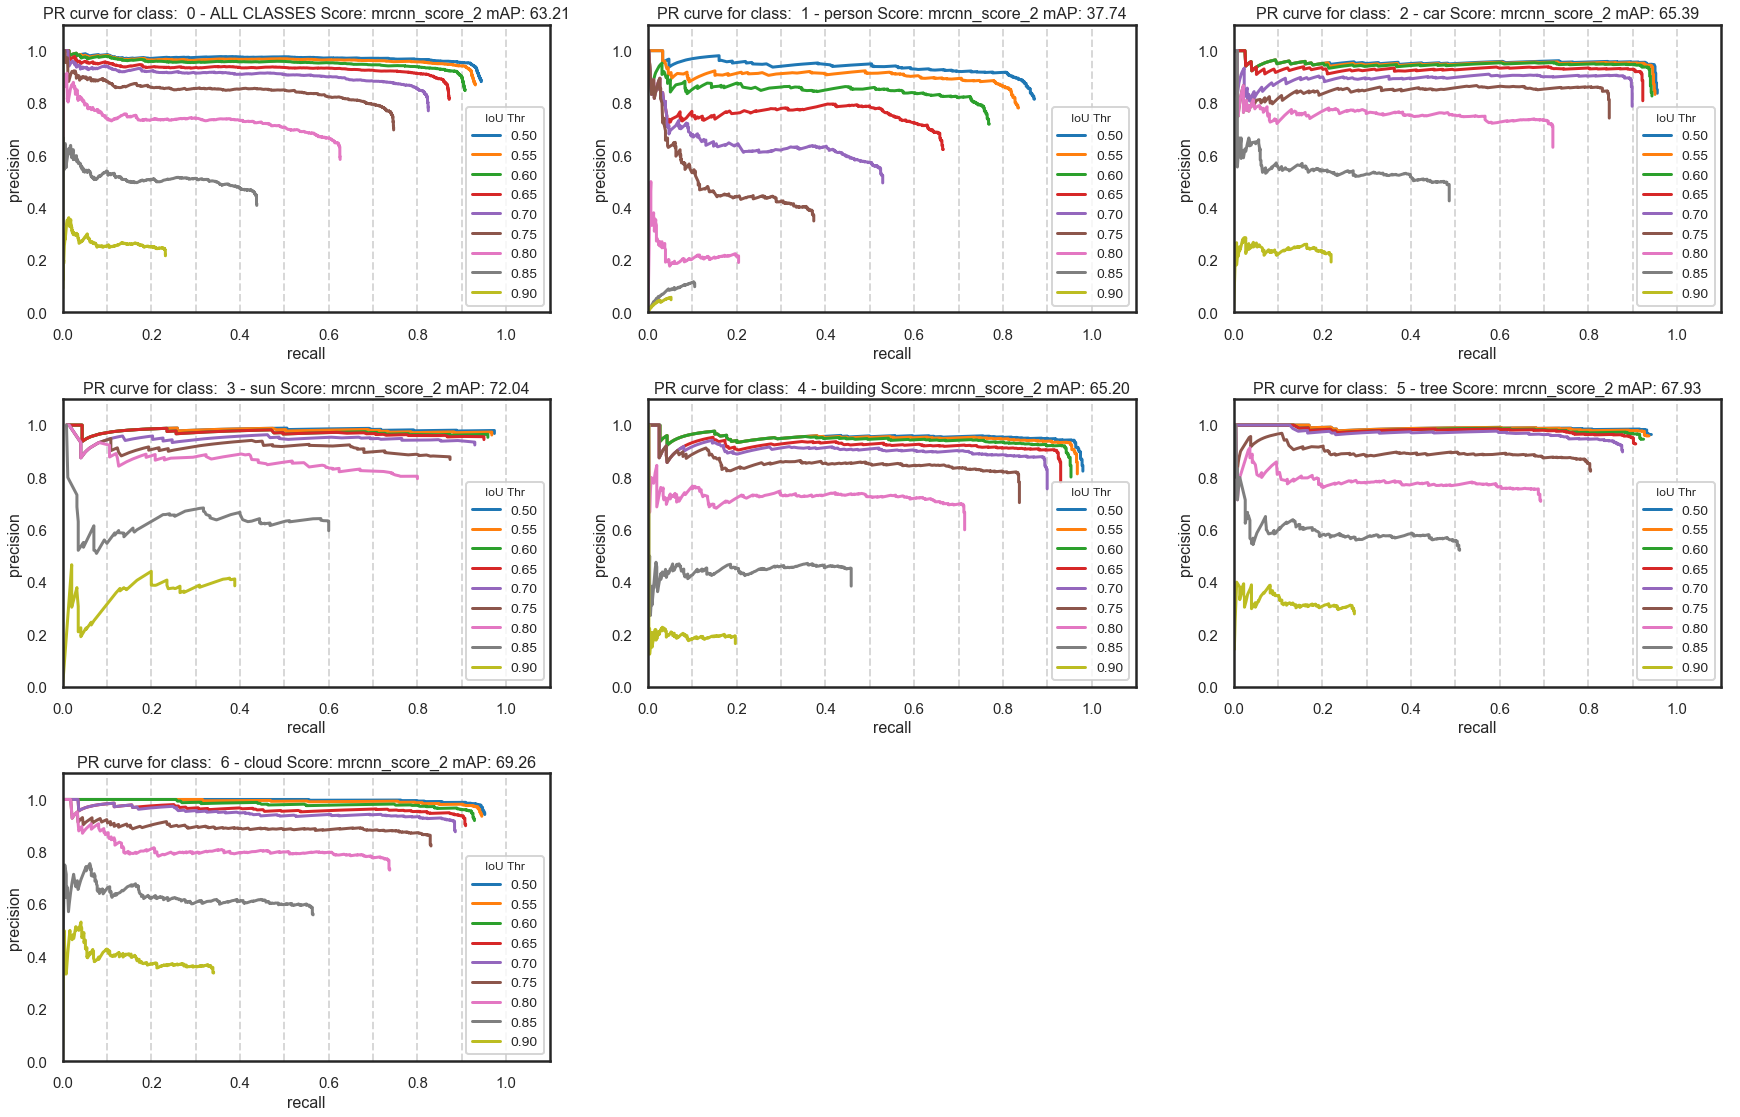

In [203]:
cmap.plot_mAP_by_IOU(all_data, 'mrcnn_score_2', class_names = class_names )

### Plot mAP for `fcn_score_1`

['ALL CLASSES', 'person', 'car', 'sun', 'building', 'tree', 'cloud']

                                           AP @ IoU Thresholds for Score Computation: fcn_score_1                                           

-------------------------------------------------------------  IoU Thresholds  -------------------------------------------------------------
Id - ClassName                    0.5000     0.5500     0.6000     0.6500     0.7000     0.7500     0.8000     0.8500     0.9000       mAP
--------------------------------------------------------------------------------------------------------------------------------------------
  0 - ALL CLASSES                 0.8936     0.8888     0.8758     0.7834     0.7632     0.6488     0.5121     0.2951     0.0861      %63.85 
  1 - person                      0.7820     0.7666     0.6538     0.5250     0.3920     0.2230     0.0767     0.0315     0.0081      %38.43 
  2 - car                         0.8900     0.8894     0.8823     0.8715     0.779

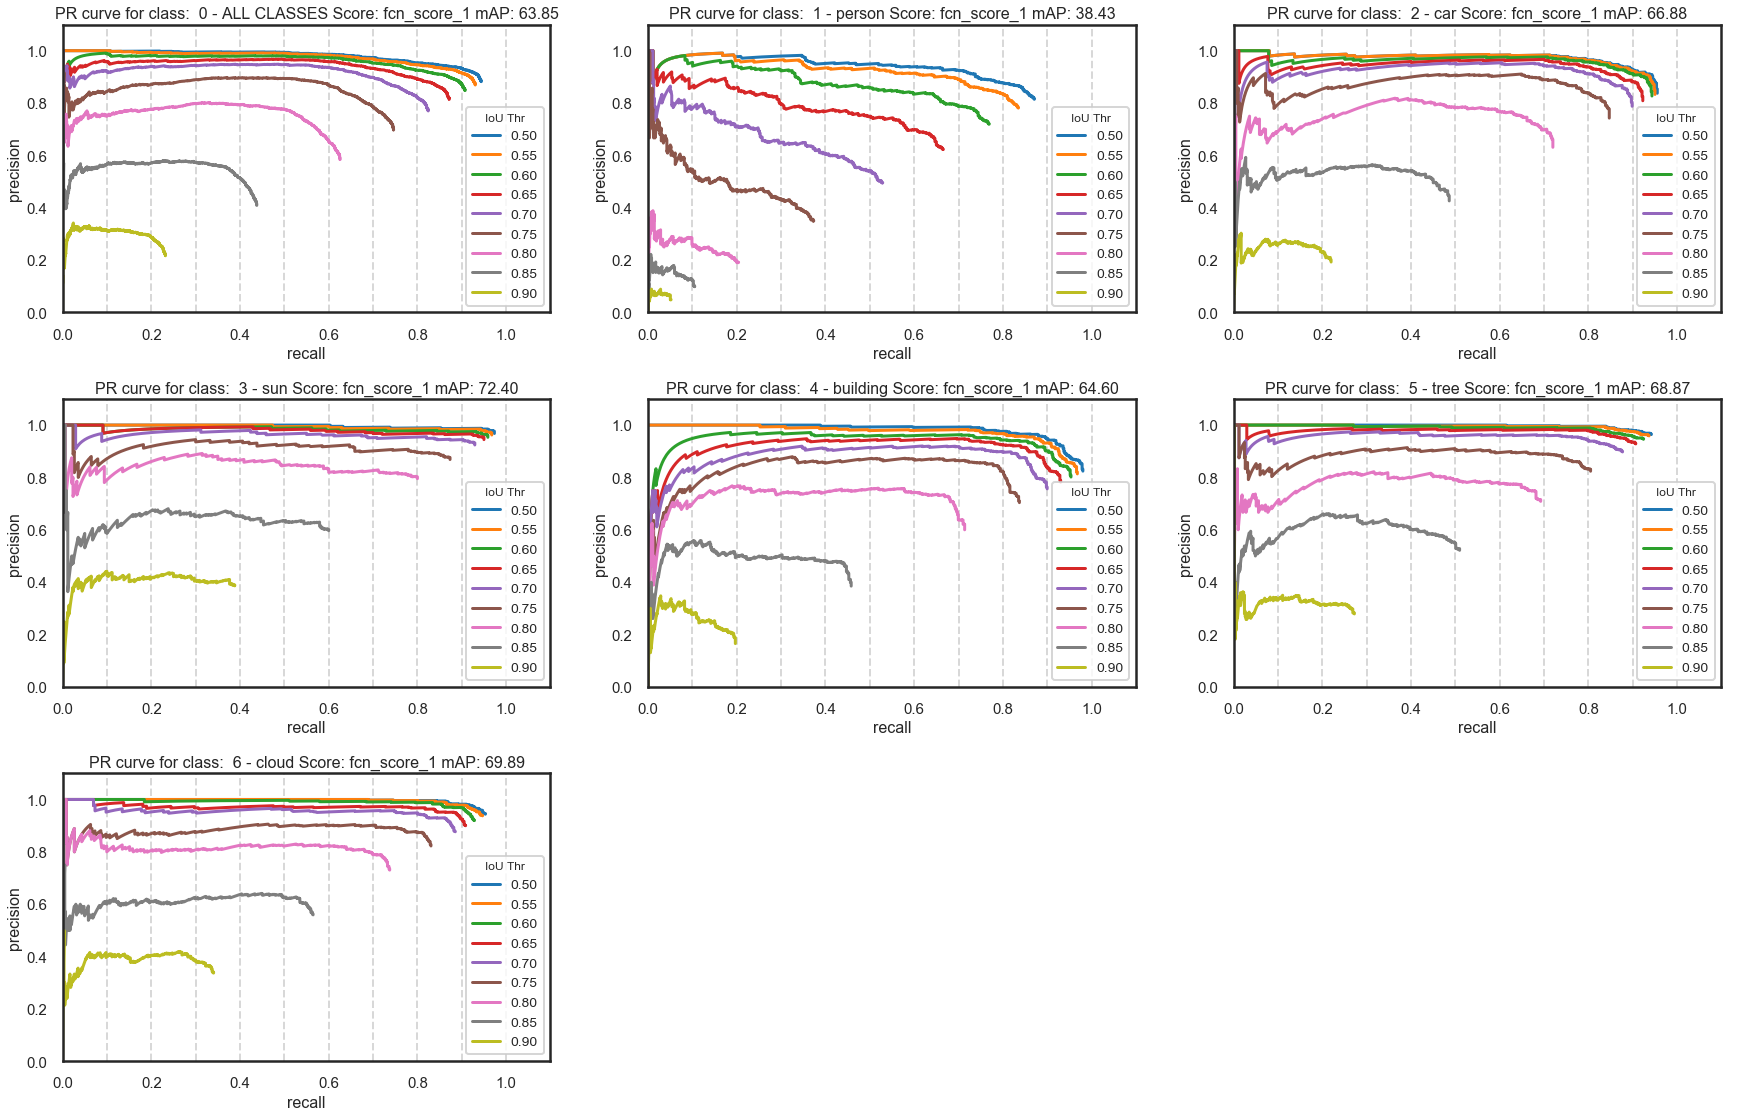

In [204]:
cmap.plot_mAP_by_IOU(all_data, 'fcn_score_1', class_names = class_names )

### Plot mAP for `fcn_score_2`

['ALL CLASSES', 'person', 'car', 'sun', 'building', 'tree', 'cloud']

                                           AP @ IoU Thresholds for Score Computation: fcn_score_2                                           

-------------------------------------------------------------  IoU Thresholds  -------------------------------------------------------------
Id - ClassName                    0.5000     0.5500     0.6000     0.6500     0.7000     0.7500     0.8000     0.8500     0.9000       mAP
--------------------------------------------------------------------------------------------------------------------------------------------
  0 - ALL CLASSES                 0.8915     0.8823     0.8630     0.7641     0.7296     0.6058     0.4672     0.2758     0.0822      %61.79 
  1 - person                      0.7774     0.7498     0.6305     0.5050     0.3687     0.2149     0.0617     0.0245     0.0064      %37.10 
  2 - car                         0.8857     0.8838     0.8769     0.8630     0.770

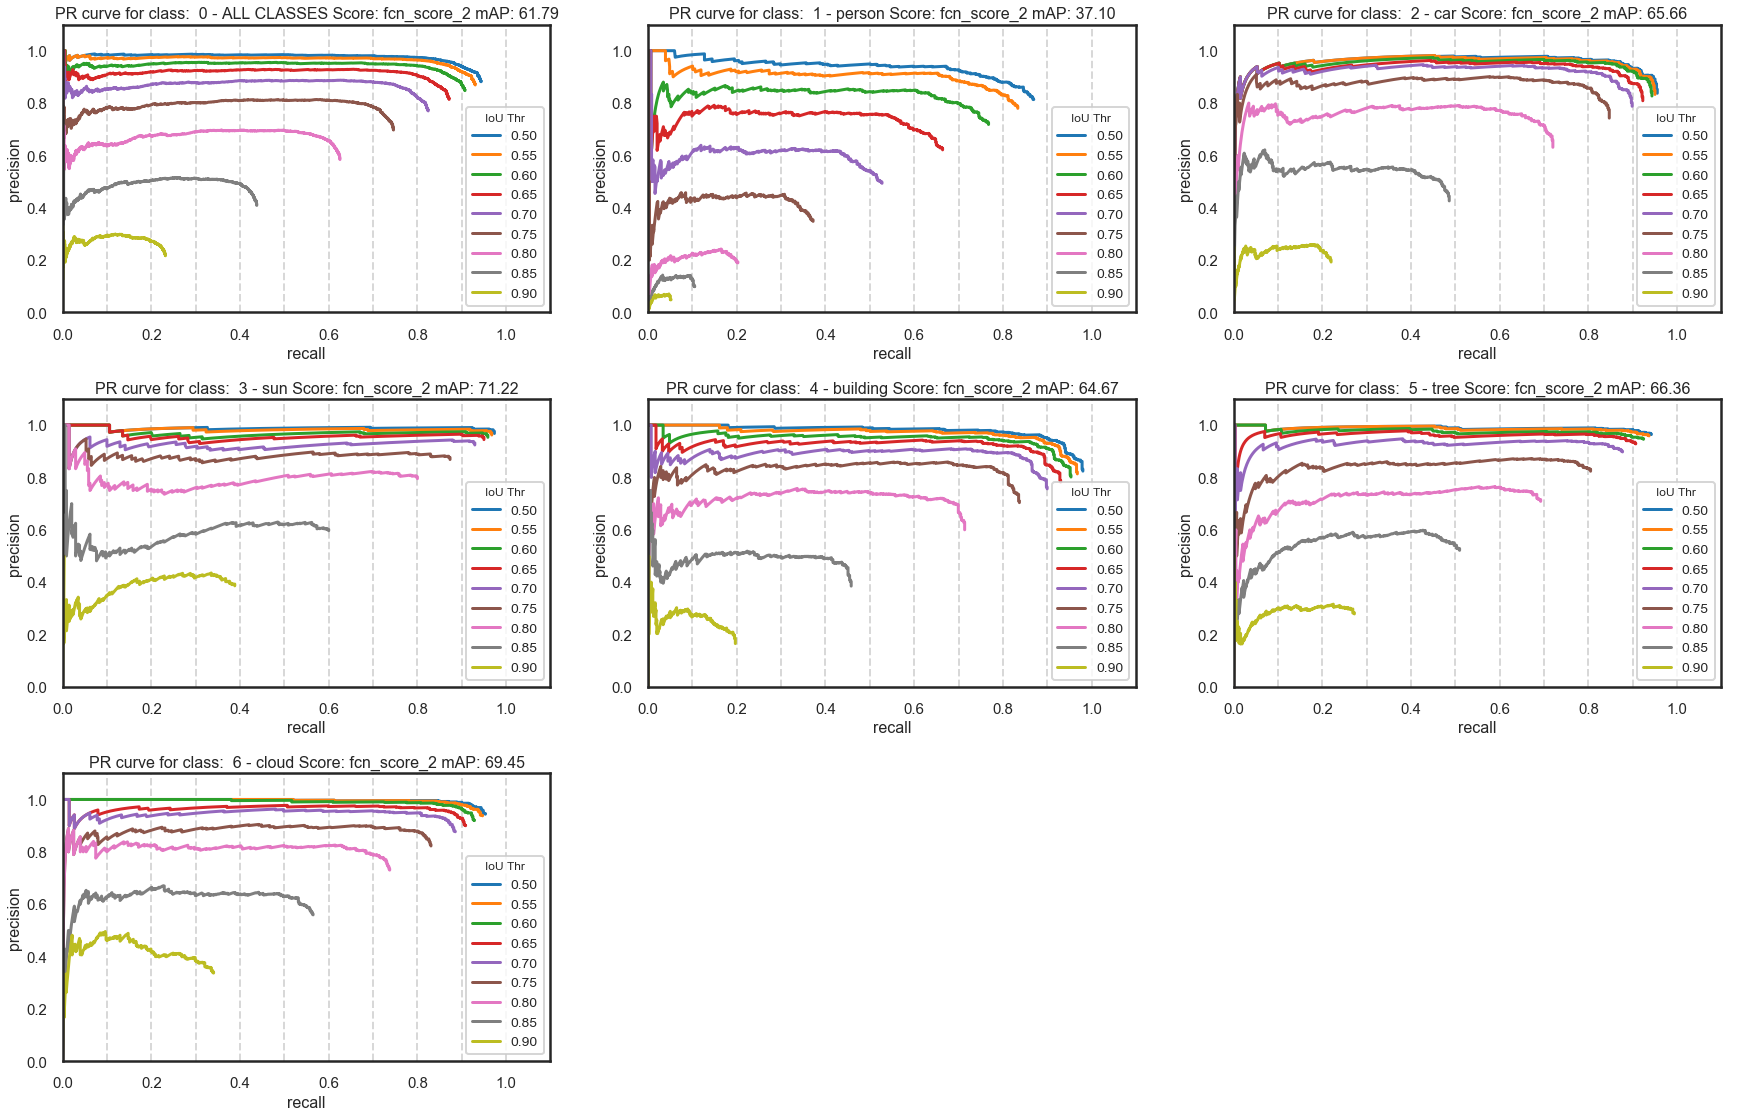

In [205]:
cmap.plot_mAP_by_IOU(all_data, 'fcn_score_2', class_names = class_names )

## Indvidual classes - Plot mAP info for different scores (at a given IoU threshold)

###  Calculate information for one class at one  threshold with different scores, e.g. 'scores')


                                                               AP @ IoU 0.75 Thresholds for Computed Scores                                                               

--------------------------------------------------------------------------------  scores  --------------------------------------------------------------------------------
Id - ClassName           mrcnn_score_orig  mrcnn_score_norm     mrcnn_score_0     mrcnn_score_1     mrcnn_score_2       fcn_score_0       fcn_score_1       fcn_score_2
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 0 - ALL CLASSES                   0.6545            0.5997            0.6493            0.6297            0.6299            0.5069            0.6488            0.6058 
 1 - person                        0.1987            0.1603            0.1734            0.2217            0.2199            0.1417            0.223

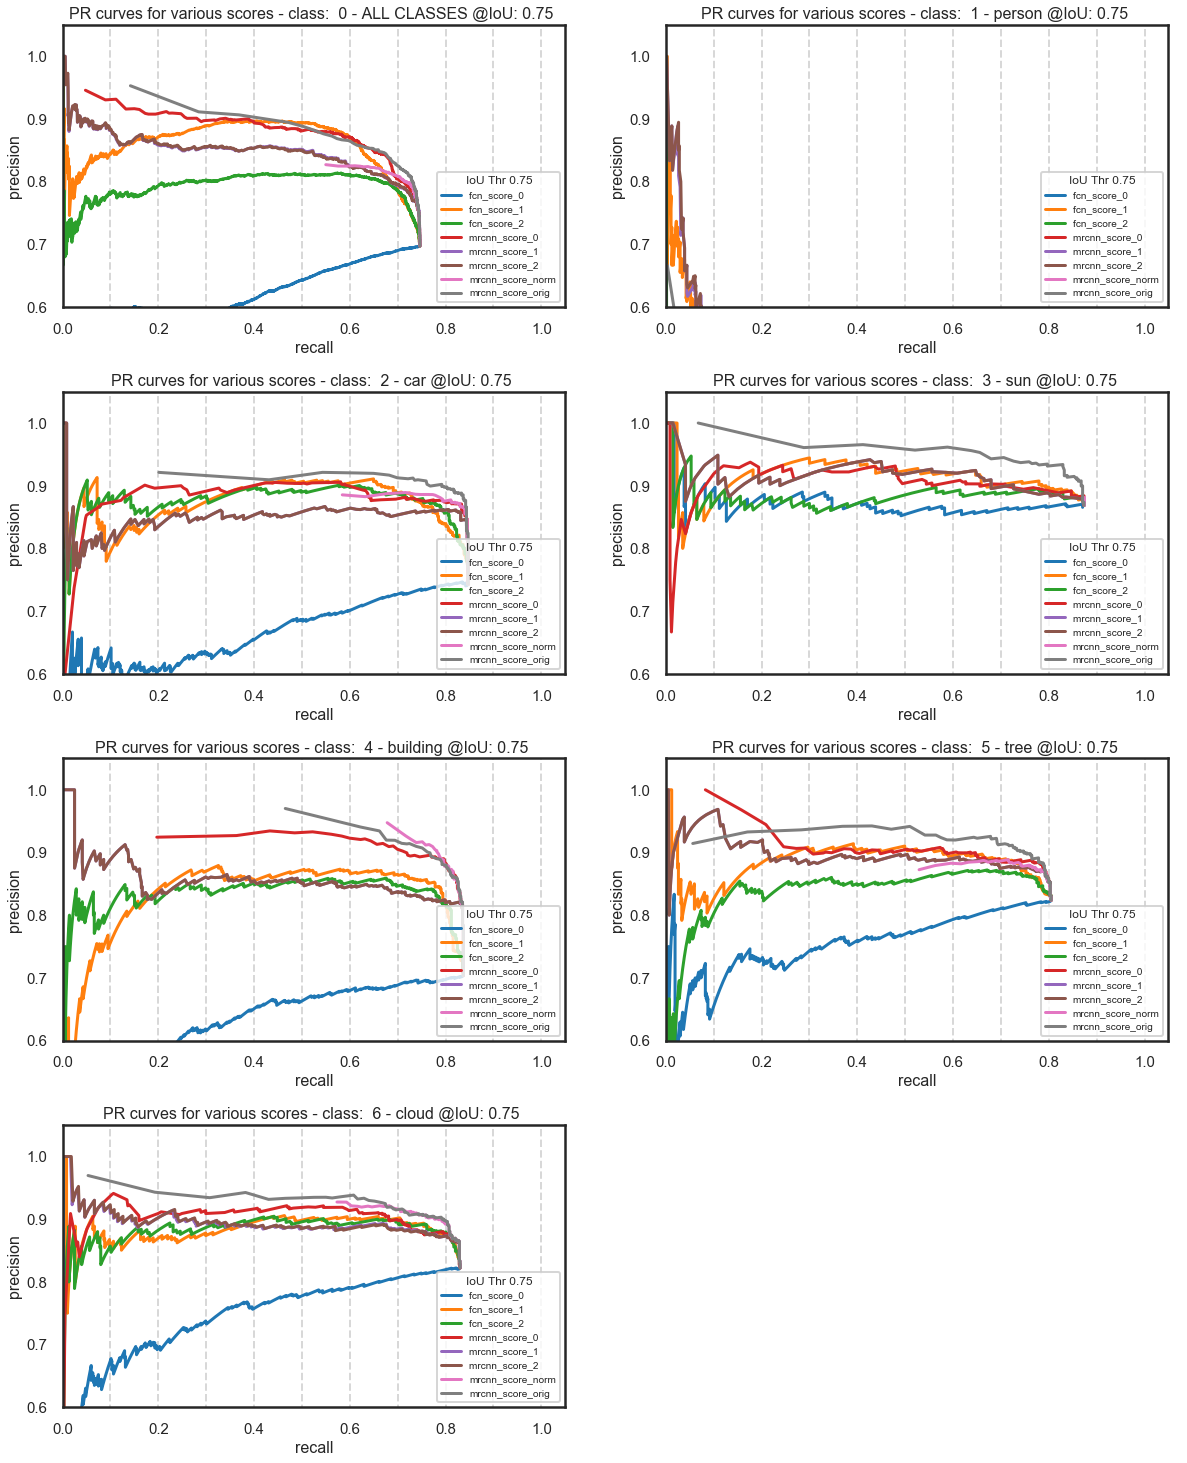

In [213]:
disp_classes = [0,1,2,3,4,5,6]  
disp_scores  = [ 'mrcnn_score_orig' , 'mrcnn_score_norm', 'mrcnn_score_0', 'mrcnn_score_1', 'mrcnn_score_2', 'fcn_score_0', 'fcn_score_1', 'fcn_score_2']
cmap.plot_mAP_by_scores(all_data, scores = disp_scores, class_ids = disp_classes, class_names= class_names, iou = 0.75)

In [168]:
# cls = 1
# for i in pr_boxes_class[cls]:
#     print(i)
#     print(pr_boxes_class[cls][i]['scores'])
#     print(pr_boxes_class[cls][i]['mrcnn_score_orig'])
#     print(pr_boxes_class[cls][i]['mrcnn_score_norm'])
#     print('---------')

In [361]:
pp.pprint(all_data[1].keys())

dict_keys(['fcn_score_2', 'mrcnn_score_2', 'fcn_score_0', 'mrcnn_score_orig', 'scores', 'mrcnn_score_1', 'fcn_score_1', 'mrcnn_score_norm', 'mrcnn_score_0'])


In [1]:
# pp.pprint(all_data[1]['mrcnn_score_norm'])

In [ ]:
pp.pprint(all_data[1]['mrcnn_score_orig'])

In [ ]:
pp.pprint(all_data[1]['scores'])

In [ ]:
print(all_data[1]['mrcnn_score_0'])

In [ ]:
print(all_data[1]['mrcnn_score_1'])

In [ ]:
print(all_data[1]['mrcnn_score_2'])

In [ ]:
print(all_data[1]['scores'] == all_data[1]['mrcnn_score_orig'])

In [ ]:
for idx, iou_thr in enumerate(np.linspace(0.5, 0.95, 10)):
    print(idx, iou_thr, np.round(iou_thr,2))
for idx, iou_thr in enumerate(np.arange(0.5, 0.95, 0.05)):
    print(idx, iou_thr)    
for idx, iou_thr in enumerate(range(0.5, 0.95,  0.05)):
    print(idx, iou_thr)    

## Code from `calculate_mean_ap.py`

### `get_models_scores_map()`

In [ ]:
def get_model_scores_map(pred_boxes, score_key ):
    """Creates a dictionary of from model_scores to image ids.

    Args:
        pred_boxes (dict): dict of dicts of 'boxes' and 'scores'

    Returns:
        dict: keys are model_scores and values are image ids (usually filenames)

    """
    model_scores_map = {}
    for img_id, val in pred_boxes.items():
        for raw_score in val['scores']:
            score = round(raw_score,5)
            if score not in model_scores_map.keys():
                model_scores_map[score] = [img_id]
            else:
                model_scores_map[score].append(img_id)
    return model_scores_map

In [ ]:
from copy import deepcopy
def get_avg_precision_at_iou(in_gt_boxes, in_pred_boxes, iou_thr=0.5, score_key = 'scores'):
    '''
    Calculates average precision at given IoU threshold.

    Args:
        gt_boxes (list of list of floats): list of locations of ground truth
            objects as [xmin, ymin, xmax, ymax]
        pred_boxes (list of list of floats): list of locations of predicted
            objects as [xmin, ymin, xmax, ymax]
        iou_thr (float): value of IoU to consider as threshold for a
            true prediction.

    Returns:
        dict: avg precision as well as summary info about the PR curve

        Keys:
            'avg_prec' (float): average precision for this IoU threshold
            'precisions' (list of floats): precision value for the given
                model_threshold
            'recall' (list of floats): recall value for given
                model_threshold
            'models_thrs' (list of floats): model threshold value that
                precision and recall were computed for.
    '''
    gt_boxes = deepcopy(in_gt_boxes)
    pred_boxes = deepcopy(in_pred_boxes)
    model_scores_map    = get_model_scores_map(pred_boxes, score_key = score_key)
    sorted_model_scores = sorted(model_scores_map.keys())
    print('sorted_model_scores :' , sorted_model_scores)
    
    ## Sort the predicted boxes in ascending score order (lowest scoring boxes first):
    for img_id in pred_boxes.keys():
        
        arg_sort = np.argsort(pred_boxes[img_id][score_key])
        print()
        print('image_id : ', img_id)
        print('--------------------------')
        print('scores:', pred_boxes[img_id]['scores'] )
        print(score_key, ':' ,pred_boxes[img_id][score_key] )
        print(pred_boxes[img_id]['boxes'] )
        print('argsort:' , arg_sort)
        pred_boxes[img_id]['scores'] = np.array(pred_boxes[img_id][score_key])[arg_sort].tolist()
        pred_boxes[img_id]['boxes']  = np.array(pred_boxes[img_id]['boxes'])[arg_sort].tolist()
        print('after')
        print('--------------------------')
        print('scores:', pred_boxes[img_id]['scores'] )
        print(score_key, ':' ,pred_boxes[img_id][score_key] )
        print(pred_boxes[img_id]['boxes'] )
        
        
    pred_boxes_pruned = deepcopy(pred_boxes)

    precisions  = []
    recalls     = []
    model_thrs  = []
    img_results = {}
    
    # Loop over model score thresholds and calculate precision, recall
    for ithr, model_score_thr in enumerate(sorted_model_scores[:-1]):
        # On first iteration, define img_results for the first time:
        print('------------------------------------------------')
        print('ithr ', ithr, 'model_scr_thr', model_score_thr)
        print('------------------------------------------------')
        img_ids = gt_boxes.keys() if ithr == 0 else model_scores_map[model_score_thr]
        for img_id in img_ids:
            gt_boxes_img = gt_boxes[img_id]['boxes']
            box_scores = pred_boxes_pruned[img_id]['scores']
            start_idx = 0
            for score in box_scores:
                if score <= model_score_thr:
#                     pred_boxes_pruned[img_id]
                    start_idx += 1
                else:
                    break
            print('Start Idx is ', start_idx)
            # Remove boxes, scores of lower than threshold scores:
            pred_boxes_pruned[img_id]['scores'] = pred_boxes_pruned[img_id]['scores'][start_idx:]
            pred_boxes_pruned[img_id]['boxes']  = pred_boxes_pruned[img_id]['boxes'][start_idx:]

            # Recalculate image results for this image
            img_results[img_id] = cmap.get_single_image_results(
                gt_boxes_img, pred_boxes_pruned[img_id]['boxes'], iou_thr)
            print('image_id : ', img_id)
            print('--------------------------')            
            pp.pprint(gt_boxes_img)
            pp.pprint(pred_boxes_pruned[img_id]['boxes'])
            pp.pprint(img_results[img_id])
            print()
        prec, rec = cmap.calc_precision_recall(img_results)
        print('precision:', prec, 'Recall:', rec)
        precisions.append(prec)
        recalls.append(rec)
        model_thrs.append(model_score_thr)

    precisions = np.array(precisions)
    recalls = np.array(recalls)
    print('final precsions:', precisions)
    print('final recall   :', recalls)
    prec_at_rec = []
    for recall_level in np.linspace(0.0, 1.0, 11):
        try:
            args = np.argwhere(recalls >= recall_level).flatten()
            prec = max(precisions[args])
        except ValueError:
            prec = 0.0
        prec_at_rec.append(prec)
    avg_prec = np.mean(prec_at_rec)

    return {
        'avg_prec': avg_prec,
        'precisions': precisions,
        'recalls': recalls,
        'model_thrs': model_thrs}


In [ ]:
class_ids = [1,2,3,4,5,6]
## build gt_boxes_class, pr_boxes_class which only containing info for each class 
gt_boxes_class = {}
pr_boxes_class = {}

for cls in class_ids :
    print('class id :', cls)
    a, b = filter_by_class(gt_boxes, pr_boxes, class_id= cls)
    gt_boxes_class[cls] = a
    pr_boxes_class[cls] = b
print(gt_boxes_class.keys())    
print(pr_boxes_class.keys())    
print(gt_boxes_class[1]['newshapes_00992'].keys())


In [ ]:
# msm = get_model_scores_map(pr_boxes_class[1], score_key = 'scores') 
print(pr_boxes_class[1].keys())
print(pr_boxes_class[1]['newshapes_00992']['mrcnn_score_orig'])
print(pr_boxes_class[1]['newshapes_00992']['scores'])
print(pr_boxes_class[1]['newshapes_00992']['boxes'])
print(pr_boxes_class[1]['newshapes_00992']['det_ind'])
print(gt_boxes_class[1]['newshapes_00992']['boxes'])

In [ ]:
# msm = get_model_scores_map(pr_boxes_class[1], score_key = 'scores') 
print(pr_boxes_class[1].keys())
print(pr_boxes_class[1]['newshapes_00992']['mrcnn_score_orig'])
print(pr_boxes_class[1]['newshapes_00992']['scores'])
print(pr_boxes_class[1]['newshapes_00992']['boxes'])
print(pr_boxes_class[1]['newshapes_00992']['det_ind'])
print(gt_boxes_class[1]['newshapes_00992']['boxes'])

print()

print(pr_boxes['newshapes_00992']['class_ids'])
print(pr_boxes['newshapes_00992']['mrcnn_score_orig'])
print(pr_boxes['newshapes_00992']['scores'])
print(pr_boxes['newshapes_00992']['boxes'])

In [ ]:
data1 = get_avg_precision_at_iou(gt_boxes_class[1], pr_boxes_class[1], iou_thr= 0.5, score_key = 'scores')
print(data1)

In [ ]:
print(pr_boxes_class[1].keys())
print(pr_boxes_class[1]['newshapes_00992']['mrcnn_score_orig'])
print(pr_boxes_class[1]['newshapes_00992']['scores'])
print(pr_boxes_class[1]['newshapes_00992']['boxes'])
print(pr_boxes_class[1]['newshapes_00992']['det_ind'])
print(gt_boxes_class[1]['newshapes_00992']['boxes'])

In [ ]:
data2 = get_avg_precision_at_iou(gt_boxes_class[1], pr_boxes_class[1], iou_thr= 0.5, score_key = 'mrcnn_score_orig')
print(data2)

In [ ]:
print(data1)
print(data2)

In [ ]:
print(pr_boxes_class[1].keys())
print(pr_boxes_class[1]['newshapes_00992']['mrcnn_score_orig'])
print(pr_boxes_class[1]['newshapes_00992']['scores'])
print(pr_boxes_class[1]['newshapes_00992']['boxes'])
print(pr_boxes_class[1]['newshapes_00992']['det_ind'])
print(gt_boxes_class[1]['newshapes_00992']['boxes'])

In [ ]:
data3 = cmap.get_avg_precision_at_iou(gt_boxes_class[1], pr_boxes_class[1], iou_thr= 0.5, score_key = 'mrcnn_score_orig')
print(data3)

In [ ]:
print(pr_boxes_class[1].keys())
print(pr_boxes_class[1]['newshapes_00992']['mrcnn_score_orig'])
print(pr_boxes_class[1]['newshapes_00992']['scores'])
print(pr_boxes_class[1]['newshapes_00992']['boxes'])
print(pr_boxes_class[1]['newshapes_00992']['det_ind'])
print(gt_boxes_class[1]['newshapes_00992']['boxes'])

In [ ]:
data4 = cmap.get_avg_precision_at_iou(gt_boxes_class[1], pr_boxes_class[1], iou_thr= 0.5, score_key = 'scores')
print(data4)

In [ ]:
data5 = cmap.get_avg_precision_at_iou(gt_boxes_class[1], pr_boxes_class[1], iou_thr= 0.5, score_key = 'mrcnn_score_norm')
print(data5)

In [ ]:
print(data3)
print(data4)
print(data5)

In [ ]:
print(pr_boxes_class[1].keys())
print(pr_boxes_class[1]['newshapes_00992']['mrcnn_score_norm'])
print(pr_boxes_class[1]['newshapes_00992']['mrcnn_score_orig'])
print(pr_boxes_class[1]['newshapes_00992']['scores'])
print(pr_boxes_class[1]['newshapes_00992']['boxes'])
print(pr_boxes_class[1]['newshapes_00992']['det_ind'])
print(gt_boxes_class[1]['newshapes_00992']['boxes'])